In [1]:
import tensorflow as tf
from pandas.plotting._matplotlib import scatter_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyodbc
import os
import math 


Parametre, ktorými sa dá aplikácia jemne nastaviť 
- database = tabulka z ktorej sa budu vytahovat informacie
- zastavky = zoznam zastávok, ktoré bude aplikácia sledovať

In [2]:
database = '[CZ-PREOS_GTN]'
zastavky = ['Ostrava-Svinov', 'Polanka n. O.', 'Jistebník', 'Studénka', 'Suchdol nad Odr.', 'Polom',
                'Hranice na Mor.', 'Drahotue', 'Lipník nad Beèv.', 'Prosenice', 'Pøerov os.n.', 'Výh Dluhonice']

Funkcie ktoré pomáhaju so spacovaním dát
- outlier_treatment = odstráni z dát outliery na základe IQR
- track%monitor = vyberie z dát iba tie, ktoré majú určenú trasu pomocou zoznamu zástavok a sleduje meškanie na každej zástavke

In [3]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range


def track_monitor(stops_list, df_p, title, directory):
    cesty = {}
    lastId = -1
    for index, row in df_p.iterrows():
        trainId = row['TrainId']
        if (row['FromName'] in stops_list) & (row['ToName'] in stops_list):
            if trainId == lastId:
                cesty.setdefault(trainId, []).append(row['RealDrivingTime'])
            elif (row['SectIdx'] == 0) & (row['FromName'] == stops_list[0]):
                cesty[row['TrainId']] = [0.0, row['RealDrivingTime']]
                lastId = trainId
        else:
            if trainId == lastId:
                cesty.pop(lastId, None)

    total = [0] * len(stops_list)
    
    trainsCount = 0
    for value in cesty.values():
        if len(value) == 11:
            plt.plot(zastavky, value)
            total = np.add(value, total)
            trainsCount += 1
    plt.title(title)
    plt.xticks(fontsize=7, rotation=15)
    plt.savefig(directory + 'AllTrains')
    plt.close()

    dividers = [trainsCount] * len(stops_list)

    means = np.divide(total, dividers)

    plt.title(title)
    plt.xticks(fontsize=7, rotation=15)
    plt.plot(zastavky, means)
    plt.savefig(directory + 'Mean')
    plt.close()

Nastavenia ktore dovoluju pandas zobrazit cely dataframe ako tabulku
- neodporúča sa používať
- môže spôsobiť spadnutie systému pri veľkom množstve dát 
- použivať iba na kontrolu

In [4]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)

Select ktorý z databázy vytiahne všetky potrebné dáta.
- TrainId = unikátny kľúč vlaku, spája jednu celú jazdu vlaku
- FromName = Meno zastávky úseku, odkiaľ vlak vyráža
- ToName = Meno zastávky úseku, kam vlak smeruje
- TrainType = Typ Vlaku = (Os,Ex,R,Nex,Pn,Vlec,Sluz, atď.)
- Length = dĺžka vlaku v metroch 
- CarCount = počet vagónov vlaku na danom úseku vrátane pohonných súprav
- AxisCount = počet náprav vlaku
- EngineType = typ pohonnej súpravy
- DepRealTimeStamp = timestamp reálneho odchodu zo zástavky
- ArrRealTimeStamp = timestamp reálneho príchodu do cieľovej zastávky
- DepPlanTimeStamp = timestamp plánovaného odchodu zo zástavky
- ArrPlanTimeStamp = timestamp plánovaného príchodu do cieľovej zastávky
- PlanDrivingTime = plánované trvanie cesty v sekundách
- DelayDeparture = meškanie odchodu vlaku zo stanice v sekundách 
- DelayArrive = meškanie príchodu vlaku do stanice v sekundách 
- LengthSect = dĺžka úseku v km
- PredLength = dĺžka predošlého úseku v km
- SectIdx = poradie úseku v ceste vlaku (0 = 1. úsek, 1 = 2. úsek)
- Season = ročné obdobie v ktorom sa cesta uskutočnila
- DayTime = obdobie dňa v ktorom sa trasa uskutočnila(Ráno, Obed, Večer, Noc)


In [ ]:
cnxn = pyodbc.connect("Driver={SQL Server};"
                      "Server=dokelu.kst.fri.uniza.sk;"
                      "Database=TrainsDB20-01-23;"
                      "uid=Lukas;pwd=lukas")

df = pd.read_sql_query(
      'SELECT [TrainId]'
      ',[FromName]'
      ',[ToName]'
      ',[TrainType]'
      ',[Weight]'
      ',[Length]'
      ',[CarCount]'
      ',[AxisCount]'
      ',SUBSTRING([EngineType],1,4) as EngineType'
      ',DATEDIFF(SECOND,\'1970-01-01\',[DepRealTime]) as DepRealTimeStamp'
      ',DATEDIFF(SECOND,\'1970-01-01\',[ArrRealTime]) as ArrRealTimeStamp'
      ',DATEDIFF(SECOND,\'1970-01-01\',[DepPlanTime]) as DepPlanTimeStamp'
      ',DATEDIFF(SECOND,\'1970-01-01\',[ArrPlanTime]) as ArrPlanTimeStamp'
      ',COALESCE(DATEDIFF(SECOND,\'1970-01-01\',[ArrPlanTime])-DATEDIFF(SECOND,\'1970-01-01\',[DepPlanTime]),0) as PlanDrivingTime'
      ',COALESCE(DATEDIFF(SECOND,\'1970-01-01\',[DepRealTime])-DATEDIFF(SECOND,\'1970-01-01\',[DepPlanTime]),0) as DelayDeparture'
      ',COALESCE(DATEDIFF(SECOND,\'1970-01-01\',[ArrRealTime])-DATEDIFF(SECOND,\'1970-01-01\',[ArrPlanTime]),0) as DelayArrive'
      ',COALESCE([LengthSect],0) as LengthSect'
      ',COALESCE([PredLength],0) as PredLength'
      ',SectIdx'
      ',CASE WHEN DATEPART(MONTH,DepPlanTime) in (3,4,5) then \'Jar\''
            ' WHEN DATEPART(MONTH,DepPlanTime) in (6,7,8) then \'Leto\''
            ' WHEN DATEPART(MONTH,DepPlanTime) in (9,10,11) then \'Jesen\''
            ' WHEN DATEPART(MONTH,DepPlanTime) in (12,1,2) then \'Zima\''
      ' END as Season'
      ',CASE WHEN DATEPART(HOUR,DepRealTime) in (5,6,7,8,9,10) THEN \'Rano\''
            ' WHEN DATEPART(HOUR,DepRealTime) in (11,12,13,14,15,16) THEN \'Obed\''
            ' WHEN DATEPART(HOUR,DepRealTime) in (17,18,19,20,21,22) THEN \'Vecer\''
            ' WHEN DATEPART(HOUR,DepRealTime) in (23,0,1,2,3,4) THEN \'Noc\''
     ' END as DayTime'
    ' FROM [TrainsDb20-01-23].[dbo].' + database +
    ' where DepPlanTime IS NOT NULL'
    ' and DepRealTime IS NOT NULL'
    ' and ArrRealTime IS NOT NULL'
    ' and ArrPlanTime IS NOT NULL'
    ' and Traintype not in (\'PMD\')'
    ' and Weight > 0'
    ' and Length > 0'
    ' and CarCount > 0'
    ' and AxisCount > 0'
    ' and LengthSect > 0'
    ' and FromName <> ToName'
    ' order by TrainId,SectIdx ASC'
    , cnxn)
    

Deklarácia ďalších atribútov, ktoré priamo v programe získame z dát
- PredDelay = Meškanie získané na predošlom úseku v sekundách 
- PredLength = Kvôli neúplnosti databázy túto hodnotu musíme získať dopočítaním
- DelayDiff = Získané meškanie na úseku v sekundách 
    = RealDrivingTime - PlanDrivingTime
- DelayDiffPercent = DelayDiff v pomere s Plánovaým trvaním trasy 
    = DelayDiff / PlanDrivingTime 
- NoStop = bool ktorý označuje, či vlak šiel trasu bez zastávok 
    (1 = bez zástavok, 0 = so zástavkami) - nedokončené
- PredDelayDiffPercent = DelayDiffPercent zazanmenané na predošlom úseku. Ak nemá predošlý úsek tak 0


- Ar1, Ar2, Ar3 = Rovnaký princíp ako PredDelayDiffPercent ale rozšírený na 3 predošlé úseky


In [ ]:
df['PredDelay'] = 0
df['PredLength'] = 0
df['DelayDiff'] = 0
df['DelayDiffPercent'] = 0.0
df['NoStop'] = 1
df['DelayPercent'] = 0

In [ ]:
df['Ar1'] = 0.0
df['Ar2'] = 0.0
df['Ar3'] = 0.0
df['Ar4'] = 0.0
df['Ar5'] = 0.0
df['Ar6'] = 0.0
df['Ar7'] = 0.0
df['Ar8'] = 0.0
df['Ar9'] = 0.0

In [ ]:
fromStops = df.FromName.unique()
toStops = df.ToName.unique()

Kombinácie atribútov použitých pri testovaní a filtre.

In [ ]:
train_types = ['Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Lv', 'Sp', 'Sv', 'Vlec']
stop_types = ['ZaciatokTrasy', 'PokracovanieTrasy']
season_types = ['Jar', 'Leto', 'Jesen', 'Zima']
daytime_types = ['Rano', 'Obed', 'Vecer', 'Noc']

In [ ]:
seasons_dataframes = {}
stops_dataframes = {}
train_type_dataframes = {}
daytimes_dataframes = {}

filters = {'TrainTypes': [train_types, train_type_dataframes, 'TrainType'],
           'Seasons': [season_types, seasons_dataframes, 'Season'],
           'DayTimes': [daytime_types, daytimes_dataframes, 'DayTime']}

## Filtrácia a oprava chybných dát

V tejto časti sa pokúšam opraviť dáta, a odstrániť všetky tie, ktoré podľa môjho uváženia sú nepresné alebo chybné.
Už na začiatku som niektoré dáta vyfiltroval:

#### Váha, dĺžka, počet vozňov a počet náprav musí byť kladné číslo
Táto operácia neodstánila žiadne úseky, takže dáta sú v tomto smere správne
- Weight > 0  
- Length > 0
- CarCount > 0
- AxisCount > 0

#### Dĺžka úseku musí byť kladné číslo
V tomto prípade ide o to, že úsek nesmie vycestovať z tej istej stanice ako jeho finálna stanica. Tým pádom, nesmie mať nulovú dĺžku trate. Takto som odstánil 216 záznamov
- LengthSect > 0
- FromName <> ToName

#### Nesledujem vlaky typu PMD 
Toto označenie vlaku sa používa v prípade, že vlak niekde uviazol, alebo pre zistenie, či je trať prejazdná
V databáze sa nachádza iba jeden takýto záznam
- Traintype <> PMD


#### Oprava chyby jazdných dôb spôsobených presunom na letný alebo zimný čas
Tu sa snažím lokalizovať ktoré úseky boli posunom času zasiahnuté, a následne opraviť ich jazdnú dobu a meškanie tak, aby lepšie predstavolali realitu. Zahŕňa roky 2016 - 2019
Za zmenu na letný čas bolo opravených 113 záznamov a za zimný 84

#### Jazdné doby dlhšie ako 1 minúta
Týmto som sa snažil odstrániť všetky dáta, ktoré som neopravil pri presune na zimný čas
- PlanDrivingTime > 60 = 1926 záznamov odstánených
- RealDrivingTime > 60 = 4043 záznamov odstánených

#### Vlaky ktorých reálne jazdné doby boli 4x kratšie ako plánované jazné doby
Tieto dáta sú väčšinou vlaky, ktorých jazdné doby mali trvať niekoľko hodín ale trvali menej ako 10 minút
- PlanDrivingTime/RealDrivingTime > 4 = 253 záznamov odstánených

#### Vlaky každý vozeň má aspoň 3 nápravy a dĺžku 5 metrov
Týmto spôsobom som sa snažil opraviť dáta, ktoré vykazovali menší počet náprav ako vozňov. Keď som sa bližšie na dáta pozrel, videl som, že niektoré dáta sú prehodené, a po opravení dávajú zmysel. Taktiež, žiaden vlak nemá iba jeden vozeň - tieto dáta mali v sebe najväčší počet chýb.
- usporiadanie dát CarCount < AxisCount < Length
- CarCount > 1 = odstánenie 

Odstránenie meškaní a skorých príchodov spôsobených zmenou na letný/zimný čas 

In [14]:
df.loc[(((df['DepRealTimeStamp'] > 1477792800) & (df['DepRealTimeStamp'] < 1477807200))
        # ------------------------2017-------------------------------------------------
        | ((df['DepRealTimeStamp'] > 1509242400) & (df['DepRealTimeStamp'] < 1509256800))
        # ------------------------2018-------------------------------------------------
        | ((df['DepRealTimeStamp'] > 1540692000) & (df['DepRealTimeStamp'] < 1540706400))
        # ------------------------2019-------------------------------------------------
       | ((df['DepRealTimeStamp'] > 1572141600) & (df['DepRealTimeStamp'] < 1572156000)))
       & (df['DelayDeparture'] < -1500)
       & (df['DelayDeparture'] > -5000),
       ['DelayDeparture', 'DepRealTimeStamp']] += 3600

#  -------------------------------2016-------------------------------------------------
df.loc[(((df['ArrRealTimeStamp'] > 1477792800) & (df['ArrRealTimeStamp'] < 1477807200))
        # ------------------------2017-------------------------------------------------
        | ((df['ArrRealTimeStamp'] > 1509242400) & (df['ArrRealTimeStamp'] < 1509256800))
        # ------------------------2018-------------------------------------------------
        | ((df['ArrRealTimeStamp'] > 1540692000) & (df['ArrRealTimeStamp'] < 1540706400))
        # ------------------------2019-------------------------------------------------
       | ((df['ArrRealTimeStamp'] > 1572141600) & (df['ArrRealTimeStamp'] < 1572156000)))
       & (df['DelayArrive'] < -1500)
       & (df['DelayArrive'] > -5000),
       ['DelayArrive', 'ArrRealTimeStamp']] += 3600


# zmena casu ----------------- NA LETNY-----------------------------------------------
# -------------------------------2016-------------------------------------------------
df.loc[(((df['DepRealTimeStamp'] > 1459044000) & (df['DepRealTimeStamp'] < 1459058400))
        # ------------------------2017-------------------------------------------------
        | ((df['DepRealTimeStamp'] > 1490493600) & (df['DepRealTimeStamp'] < 1490508000))
        # ------------------------2018-------------------------------------------------
        | ((df['DepRealTimeStamp'] > 1521943200) & (df['DepRealTimeStamp'] < 1521957600))
        # ------------------------2019-------------------------------------------------
       | ((df['DepRealTimeStamp'] > 1553997600) & (df['DepRealTimeStamp'] < 1554012000)))
       & (df['DelayDeparture'] > 2200)
       & (df['DelayDeparture'] < 5700),
       ['DelayDeparture', 'DepRealTimeStamp']] -= 3600

#  -------------------------------2016-------------------------------------------------
df.loc[(((df['ArrRealTimeStamp'] > 1459044000) & (df['ArrRealTimeStamp'] < 1459058400))
        # ------------------------2017-------------------------------------------------
        | ((df['ArrRealTimeStamp'] > 1490493600) & (df['ArrRealTimeStamp'] < 1490508000))
        # ------------------------2018-------------------------------------------------
        | ((df['ArrRealTimeStamp'] > 1521943200) & (df['ArrRealTimeStamp'] < 1521957600))
        # ------------------------2019-------------------------------------------------
       | ((df['ArrRealTimeStamp'] > 1553997600) & (df['ArrRealTimeStamp'] < 1554012000)))
       & (df['DelayArrive'] > 2200)
       & (df['DelayArrive'] < 5700),
       ['DelayArrive', 'ArrRealTimeStamp']] -= 3600

Výpočet viacerých atribútov, a odstránenie neplatných dát. 
- RealDrivingTime = reálny čas ktorý trvala cesta
- DelayDiff = časový rozdiel medzi reálnym časom trvania cesty a plánovaným 
- DelayDiffPercent = DelayDiff v pomere ku plánovanej časovej dĺžke trasy
- CarCount,AxisCount,Length = výmena poradia týchto atribútov aby dávali zmysel 
- PredLength = priradenie hodnoty pri chýbajúcich údajoch
- Ar1, Ar2, Ar3 = priradenie hodnoty z predchádzajúcich úsekov

In [15]:
df['RealDrivingTime'] = (df['ArrRealTimeStamp'] - df['DepRealTimeStamp'])

In [16]:
print(df.shape)
df = df[(df['PlanDrivingTime'] > 60)]
print(df.shape)
df = df[(df['RealDrivingTime'] > 60)]
print(df.shape)

(2899217, 36)
(2897291, 36)
(2893248, 36)


In [17]:
#dflargeDelay = df[((df['PlanDrivingTime'] / df['RealDrivingTime'] >= 4) | (df['RealDrivingTime'] / df['PlanDrivingTime'] >= 20))]
df = df[(df['PlanDrivingTime'] / df['RealDrivingTime'] < 4)]
#df = df[(df['RealDrivingTime'] / df['PlanDrivingTime'] < 20)]
print(df.shape)

(2892995, 36)


In [18]:
df['DelayDiff'] = (df['RealDrivingTime'] - df['PlanDrivingTime'])
df['DelayDiffPercent'] = (df['DelayDiff'] / df['PlanDrivingTime'])
df['DelayPercent'] = (df['RealDrivingTime'] / df['PlanDrivingTime'])

In [13]:
dfOld = df.copy()

In [19]:
lastId = -1
lastKm = 0

lastDelays = [0]*9

# vypocet hodnot pre dlzku predosleho useku a posledneho meskania
for index in df.index:
    # vymena stlpcov
    vymena = []
    vymena.insert(0, df.at[index, 'CarCount'])
    vymena.insert(1, df.at[index, 'AxisCount'])
    vymena.insert(2, df.at[index, 'Length'])
    vymena.sort()
    df.at[index, 'CarCount'] = vymena[0]
    df.at[index, 'AxisCount'] = vymena[1]
    df.at[index, 'Length'] = vymena[2]

    if df.at[index, 'TrainId'] == lastId:
        df.at[index, 'PredLength'] = lastKm
        
        df.at[index, 'Ar1'] = lastDelays[-1]
        df.at[index, 'Ar2'] = lastDelays[-2]
        df.at[index, 'Ar3'] = lastDelays[-3]
        df.at[index, 'Ar4'] = lastDelays[-4]
        df.at[index, 'Ar5'] = lastDelays[-5]
        df.at[index, 'Ar6'] = lastDelays[-6]
        df.at[index, 'Ar7'] = lastDelays[-7]
        df.at[index, 'Ar8'] = lastDelays[-8]
        df.at[index, 'Ar9'] = lastDelays[-9]
    else:
        lastId = df.at[index, 'TrainId']
        lastDelays = [0]*9
        
    lastDelays.append(df.at[index, 'DelayDiffPercent'])
    lastKm = df.at[index, 'LengthSect']

print(df.shape)

(2892995, 36)


In [20]:
df = df[(df['CarCount'] > 1)]
print(df.shape)

(2608252, 36)


In [24]:
df['DelayDepartureReduced'] = 0

lastId = -1
firstDelay = 0
for index in df.index:
    if df.at[index, 'TrainId'] != lastId:
        lastId = df.at[index, 'TrainId']
        firstDelay = df.at[index, 'DelayDeparture']
    df.at[index,'DelayDepartureReduced'] = df.at[index, 'DelayDeparture'] - firstDelay

In [ ]:
df['Grafikon'] = 0


1607731200

Filtre pomocou ktorých sledujem atribúty a zoznamy atrubútov na trénovanie

In [21]:
input_attributes = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'PredLength', 'PredDelay']
data_attributes = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'PredLength', 'PredDelay', 'DelayDiffPercent']
train_attributes =  ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'PredLength', 'PredDelay', 'SectIdx', 'DelayArrive', 'DelayDeparture',
                     'Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Sp', 'Sv', 'Vlec', 'Jar', 'Leto', 'Jesen', 'Zima', 'Rano', 'Obed', 'Vecer', 'Noc', 'DelayDiffPercent']




exp = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayArrive', 'DelayDeparture','PredDelayDiffPercent',
                     'Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Sp', 'Sv', 'Vlec', 'Jar', 'Leto', 'Jesen', 'Zima', 'Rano', 'Obed', 'Vecer', 'Noc', 'DelayDiffPercent']


cut = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'SectIdx', 'DelayArrive', 'DelayDeparture','PredDelayDiffPercent',
                     'Ex', 'Pn', 'R', 'Vlec', 'DelayDiffPercent']

try1_attributes =  ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx','Ar1','Ar2','Ar3',
                     'Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Sp', 'Sv', 'Vlec', 'Jar', 'Leto', 'Jesen', 'Zima', 'Rano', 'Obed', 'Vecer', 'Noc', 'PredDelayDiffPercent']




In [22]:
if not os.path.exists(database + '/AllData'):
    os.makedirs(database + '/AllData')
    os.makedirs(database + '/AllData/ScatterPlots')


## Normovanie
Normovanie prevedie všetky dáta okrem výsledkov do intervalu <0,1> a tu vidíme rozdiely

In [23]:
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

Metóda v ktorej môžeme definovať hyperparametre nášho modelu.
Definujeme počet vrstiev v sieti a počet perceptrónov v každej vrstve.
Každému perceptrónu zadeľujeme aj jeho aktivačnú funkciu, v tomto prípade relu=rectified linear unit
Nastavujeme aj optimalizér, čo je funkcia, ktorá vypočíta gradient, alebo smer, ktorým sa parametre majú upraviť pre zlepšenie výsledku. Zadávame v nej aj veľkosť kroku, teda o koľko sa parametre neurónovej siete posunú v smere gradientu.
Pri regresnom probléme ako je tento budem sledovať hlavne Mean Absolute Error a Mean Squared Error, kde náš model sa bude riadiť práve MSE.

In [25]:
def build_model(lr_par=0.01):
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(lr_par)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

Metóda PrintDot slúži iba na to, aby sme mohli sledovať priebeh účenia sa siete. Prejdenie všetkých trénovacích dát neurónovou sieťou nazývame epocha. Za každou touto epochou vykreslíme bodku, a tým vieme, že sa sieť stále účí.
Sieť sa upravuje práve medzi jednotlivými epochami.
Pre učenie siete použijeme ako maximum 1000 epoch, avšak zavedieme aj techniku early stop, ktorá zabezpečí, že ak sa sieť zachytí na nájdenom minime na dlhšiu dobu, tak predpokladáme, že našlo absolútne minimum funkcie a teda učenie ukončíme.

In [26]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 20 == 0:
            print('')
        print('.', end='')

In [27]:
EPOCHS = 150

In [28]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [29]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.002,
                              patience=5, min_lr=0.00001)

In [30]:
def save_best_model(model_name):
    return keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)

In [31]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [DelayDiffPercent]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    plt.legend()
    #plt.ylim([0, 200])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [$DelayDiffPercent^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    plt.legend()
    #plt.ylim([0, 100000])  

In [32]:
def eval(model):
    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

    print("Testing set Loss : {:5.2f} RealDrivingTime".format(loss))
    print("Testing set Mean Abs Error: {:5.2f} RealDrivingTime".format(mae))
    print("Testing set Mean Sqrt Error: {:5.2f} RealDrivingTime".format(mse))
    print("Testing set Root Mean Sqrt Error: {:5.2f} RealDrivingTime".format(math.sqrt(mse)))

# Prvý Test - Vytvorenie modelu zo základných dát

Na začiatok pracujem z dátami ktoré sa nachádzajú priamo v databáze. Dáta boli upravené tak, aby obsahovali čo najmenej chýb a nemožných údajov.
Pracujem teda s týmito vlastnosťami:
- Length = dĺžka vlaku v metroch 
- CarCount = počet vagónov vlaku na danom úseku vrátane pohonných súprav
- AxisCount = počet náprav vlaku
- PlanDrivingTime = plánované trvanie cesty v sekundách
- DelayDeparture = meškanie odchodu vlaku zo stanice v sekundách 
- LengthSect = dĺžka úseku v km
- PredLength = dĺžka predošlého úseku v km
- SectIdx = poradie úseku v ceste vlaku (0 = 1. úsek, 1 = 2. úsek)

a sledujem jazdnú dobu vlaku
- RealDrivingTime

In [33]:
first_attributes = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
                    'RealDrivingTime']

In [34]:
used_attributes = first_attributes
label = used_attributes[-1]

## Analýza - Výpočet lineárneho vplyvu atribútov na skúmanú vlastnosť
- korelácia so sledovanou vlastnosťou
- korelačné matice a histogram

korelácia: 

OLD
- PlanDrivingTime    0.793612
- LengthSect         0.032486
- CarCount           0.010508
- Weight             0.009368
- AxisCount          0.009147
- Length             0.004087
- DelayDeparture    -0.004585
- SectIdx           -0.007918

NEW
- PlanDrivingTime    0.788206
- CarCount           0.180204
- AxisCount          0.172168
- LengthSect         0.168778
- Weight             0.150296
- Length             0.124322
- DelayDeparture     0.087874
- SectIdx           -0.070637



In [68]:
dffcut = df[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

RealDrivingTime    1.000000
PlanDrivingTime    0.785939
CarCount           0.177143
AxisCount          0.169217
LengthSect         0.168676
Weight             0.147977
Length             0.121113
DelayDeparture     0.087346
SectIdx           -0.069235
Name: RealDrivingTime, dtype: float64


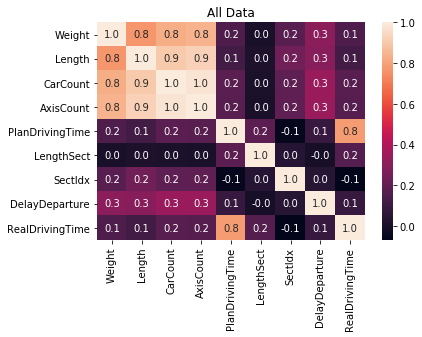

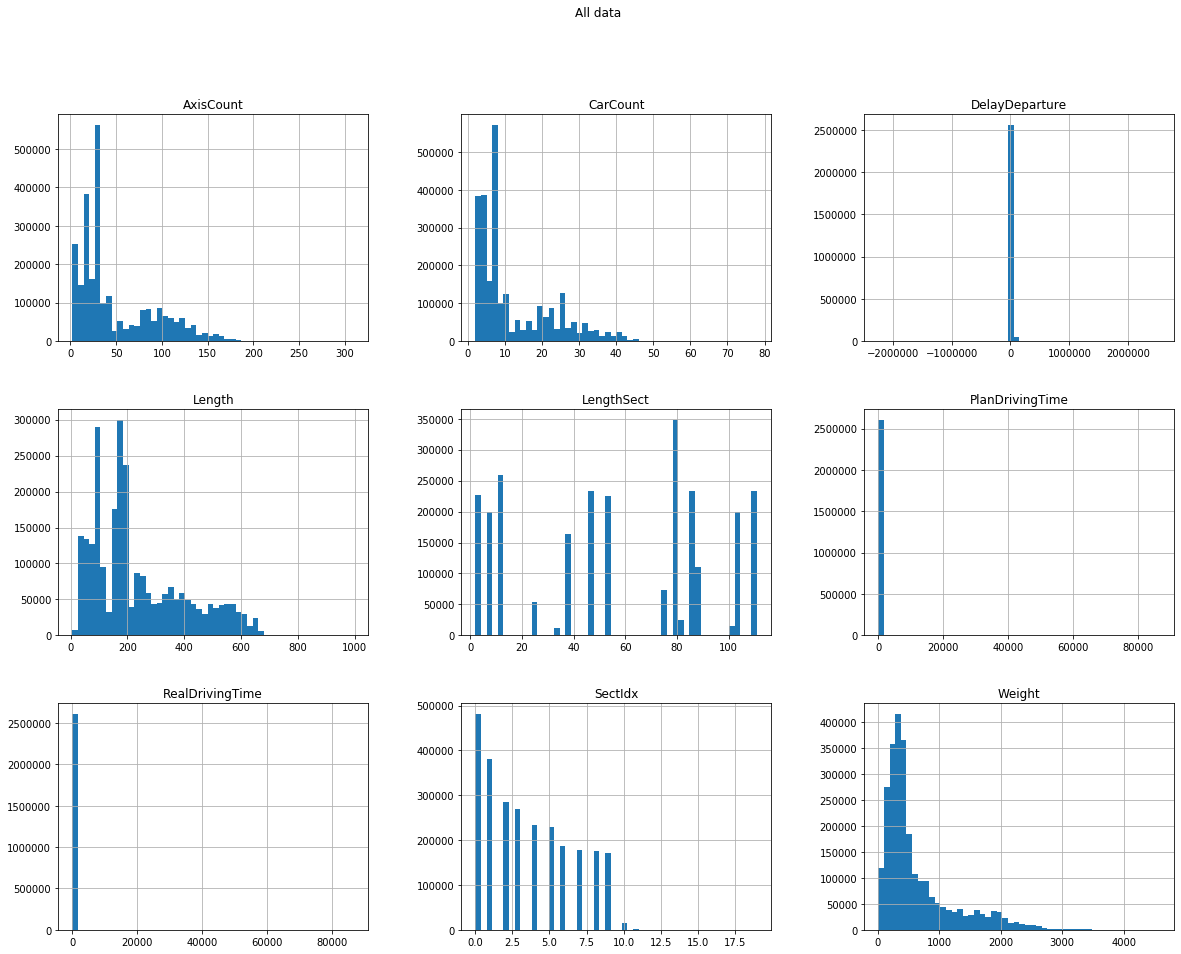

In [69]:
plt.title("All Data")
sns.heatmap(cor, annot = True, fmt='.1f')    
    
dffcut.hist(bins=50, figsize=(20, 15))
plt.suptitle("All data")
plt.show()

Porovnanie závislosti trvania trasy od parametrov trasy.
Logicky, najväčší vplyv ukazuje plánovaný čas trvania trasy(PlanDrivingTime), keďže v prípade že vlak nemešká sa tieto dve hodnoty rovnajú. Vidíme, že v dátach je mnoho outlierov.

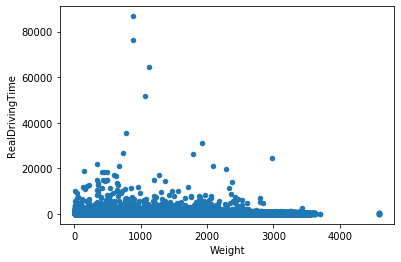

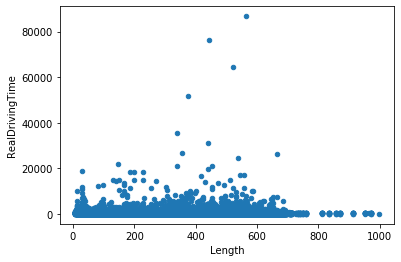

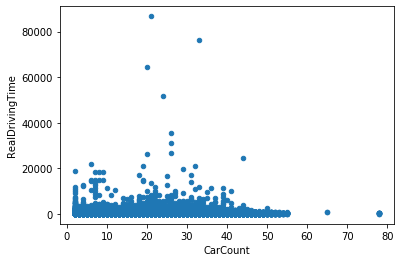

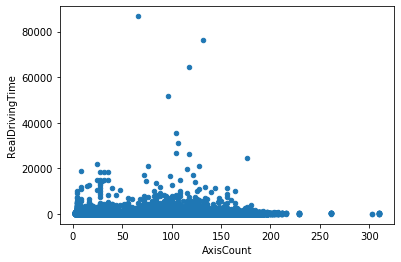

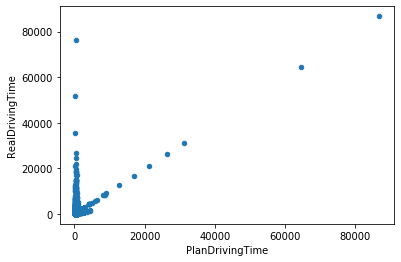

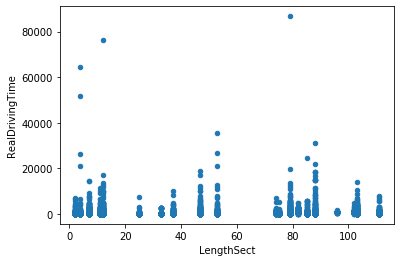

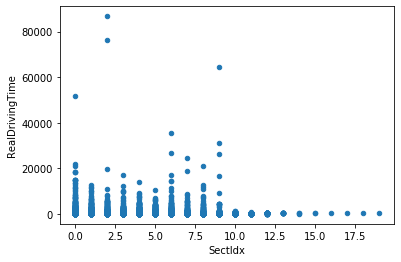

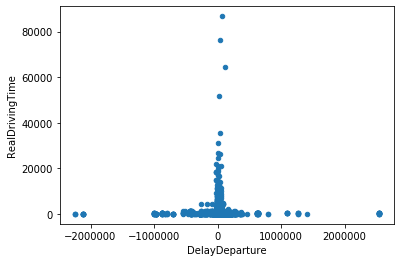

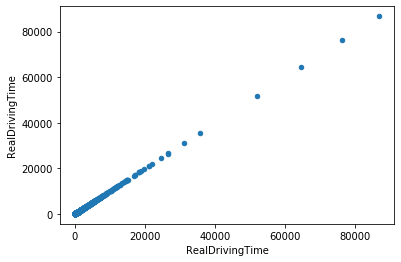

In [70]:
for attr in used_attributes:
    dffcut.plot(kind='scatter', x=attr, y=label)
    plt.show()

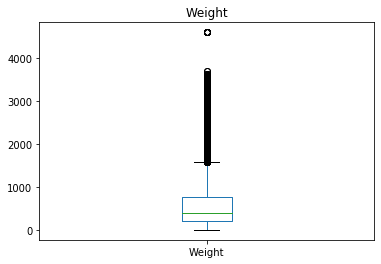

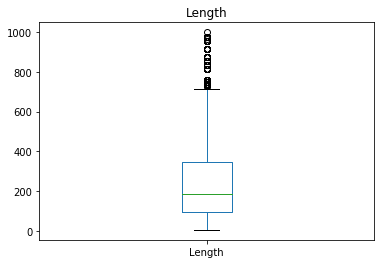

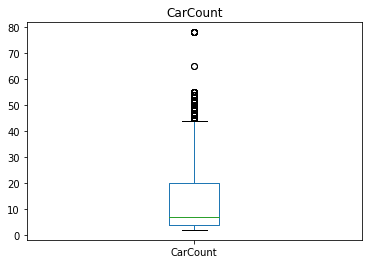

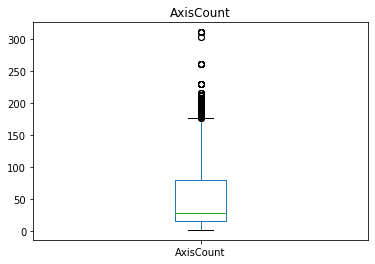

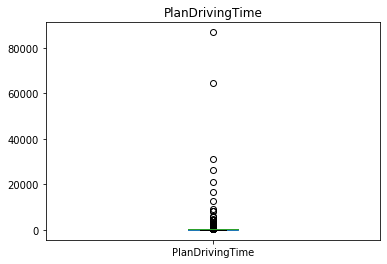

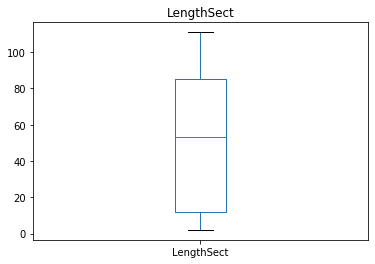

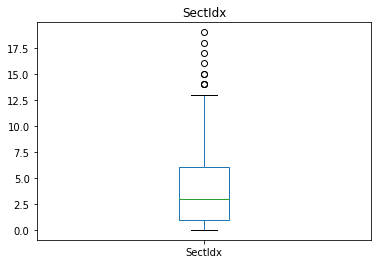

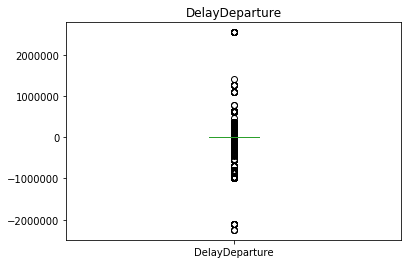

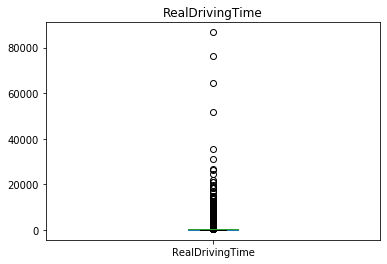

In [71]:
for attr in used_attributes:
    dffcut.plot(kind='box', y=attr)
    plt.title(attr)
    plt.show()

Zúži dataframe iba na skúmané vlastnosti. Rozdelí dataset na trénovaniu a testovaciu množinu a oddelí sledovanú vlastnosť.

In [96]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

(2086602, 8)
(521650, 8)


## Normovanie
Normovanie prevedie všetky dáta okrem výsledkov do intervalu <0,1> a tu vidíme rozdiely

In [73]:
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

In [97]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Metóda v ktorej môžeme definovať hyperparametre nášho modelu.
Definujeme počet vrstiev v sieti a počet perceptrónov v každej vrstve.
Každému perceptrónu zadeľujeme aj jeho aktivačnú funkciu, v tomto prípade relu=rectified linear unit
Nastavujeme aj optimalizér, čo je funkcia, ktorá vypočíta gradient, alebo smer, ktorým sa parametre majú upraviť pre zlepšenie výsledku. Zadávame v nej aj veľkosť kroku, teda o koľko sa parametre neurónovej siete posunú v smere gradientu.
Pri regresnom probléme ako je tento budem sledovať hlavne Mean Absolute Error a Mean Squared Error, kde náš model sa bude riadiť práve MSE.

In [138]:
def build_model(lr_par=0.01):
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(lr_par)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

In [99]:
test1Model = build_model(0.0001)
print(test1Model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None


Metóda PrintDot slúži iba na to, aby sme mohli sledovať priebeh účenia sa siete. Prejdenie všetkých trénovacích dát neurónovou sieťou nazývame epocha. Za každou touto epochou vykreslíme bodku, a tým vieme, že sa sieť stále účí.
Sieť sa upravuje práve medzi jednotlivými epochami.
Pre učenie siete použijeme ako maximum 1000 epoch, avšak zavedieme aj techniku early stop, ktorá zabezpečí, že ak sa sieť zachytí na nájdenom minime na dlhšiu dobu, tak predpokladáme, že našlo absolútne minimum funkcie a teda učenie ukončíme.

In [87]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 20 == 0:
            print('')
        print('.', end='')

In [88]:
EPOCHS = 80

In [137]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [90]:
def save_best_model(model_name):
    return keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)

Po natrénovaní siete, chcem vidieť akú presnosť mal model po jednotlivých epochách. Preto použijem metódu plot_history na ktorej grafoch zobrazujúcich vývoj MSE a MAE vidieť aj rozdiel medzi trénovacou množinou a validačnou množinou.

In [91]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [DelayDiffPercent]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [$DelayDiffPercent^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    plt.legend()

Následne začnem učenie siete, kde 25% z trénovacích dát využijem na validáciu, aby model dokázal určiť kedy dochádza k pretrénovaniu = validation loss. Teda slúži na to, aby model fungoval správne aj na dátach ktoré predtým nevidel, a teda aby zlepšoval svoju generalizáciu a zároveň nestrácal presnosť.


....................
...........

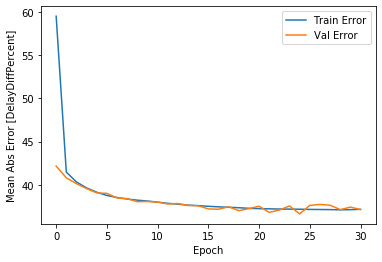

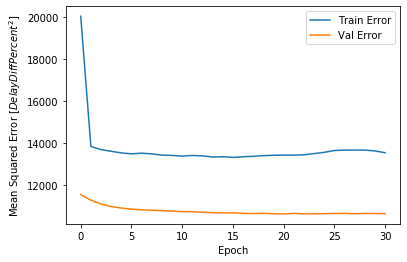

In [100]:
test1ModelFit = test1Model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model("BasicModelNew.h5"), PrintDot()])
plot_history(test1ModelFit)

In [101]:
oldtestModel = load_model("BasicModel.h5")
newtestModel = load_model("BasicModelNew.h5")

Model po natrénovaní otestujem aj na testovacích dátach. Získané hodnoty teda napovedajú o tom ako model pracuje s dátami ktoré nikdy predtým nevidel.
Sledujem MAE, MSE=Loss a RMSE ako metriky ktorými hodnotím presnosť modelu.

# Vyhodnotenie
Vidím, že model sa v priemere mýli o viac ako pol minúty. Tento model nieje na začiatok zlý. 

OLD: Pred Filtráciou

Pred filtráciou vidím, že veľa z dát sa nachádza na nemožných pozíciách. Jazdné doby sú v zápore, a to vplýva na presnosť modelu.

Najväčšia chyba: 266561 a -68279 sekúnd

- Testing set Mean Abs Error: 46.64 RealDrivingTime
- Testing set Mean Sqrt Error: 580810.81 RealDrivingTime
- Testing set Root Mean Sqrt Error: 762.11 RealDrivingTime


NEW: Po filtrácií

Na testovacej množine boli jeho najväčšie chyby 1159 sekúnd(vlak meškal o 1159 sekúnd viac ako model predpovedal) a -51679 sekúnd (model predpovedal o 51679 sekúnd kratšiu jazdnú dobu. 

- Testing set Mean Abs Error: 37.51 RealDrivingTime
- Testing set Mean Sqrt Error: 16835.85 RealDrivingTime
- Testing set Root Mean Sqrt Error: 129.75 RealDrivingTime

In [49]:
def eval(model):
    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

    print("Testing set Loss : {:5.2f} RealDrivingTime".format(loss))
    print("Testing set Mean Abs Error: {:5.2f} RealDrivingTime".format(mae))
    print("Testing set Mean Sqrt Error: {:5.2f} RealDrivingTime".format(mse))
    print("Testing set Root Mean Sqrt Error: {:5.2f} RealDrivingTime".format(math.sqrt(mse)))

In [111]:
eval(newtestModel)

Testing set Loss : 16835.84 RealDrivingTime
Testing set Mean Abs Error: 37.51 RealDrivingTime
Testing set Mean Sqrt Error: 16835.85 RealDrivingTime
Testing set Root Mean Sqrt Error: 129.75 RealDrivingTime


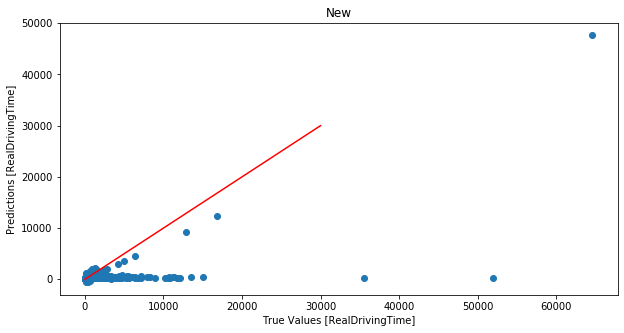

In [109]:
new_test_predictions = newtestModel.predict(normed_test_data).flatten()

plt.figure(figsize=(10,5))
plt.scatter(test_labels, new_test_predictions)
plt.title("New")
plt.xlabel('True Values [' + label + ']')
plt.ylabel('Predictions [' + label + ']')

_ = plt.plot([0,30000],[0,30000],'r')
plt.show()



Chybu vypočítame ako rozdiel medzi hodnotami, ktoré model predpovedal a ozajstnými výsledkami.
Vídím, že histogram veľkosti chýb pripomína väčšinou gaussovu krivku a teda najčastejšie sa chyby pohybujú v rozdmedzí 2 minút od ozajstnej hodnoty.
Avšak model sa pomýlil v niektorých prípadoch až o polhodinu.
Štatistika ukazuje aj, že sa pomýlil takmer o 10 hodín. Toto môže byť prípadom nesprávneho záznamu.

Najväčšia chyba:1159.335205078125
Najväčšia chyba v zápornom smere:-51679.44921875
% chýb menších ako 2 minúty: 0.9525889006038532


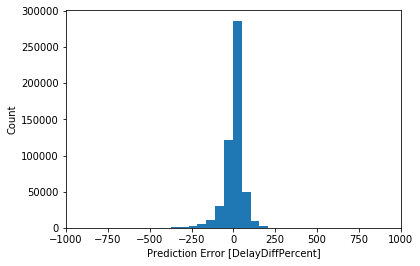

In [112]:
error = new_test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

## Experiment - nahradenie premennej DelayDeparture  DelayDepartureReduced
Táto premenná odstráni počiatočné meškanie, a sleduje meškanie získané iba od začatia trasy. 

In [113]:
Exp_reducedDelay = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDepartureReduced',
                    'RealDrivingTime']

In [114]:
used_attributes = Exp_reducedDelay
label = used_attributes[-1]

Filtrácia jazdných dôb nad 20 000 sekúnd na porovnanie zlepšenia modelu

In [115]:
#df = df[(df['PlanDrivingTime'] < 20000) | (df['RealDrivingTime'] < 20000)]

In [116]:
dffcut = df[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

RealDrivingTime          1.000000
PlanDrivingTime          0.785939
CarCount                 0.177143
AxisCount                0.169217
LengthSect               0.168676
Weight                   0.147977
Length                   0.121113
DelayDepartureReduced    0.039573
SectIdx                 -0.069235
Name: RealDrivingTime, dtype: float64


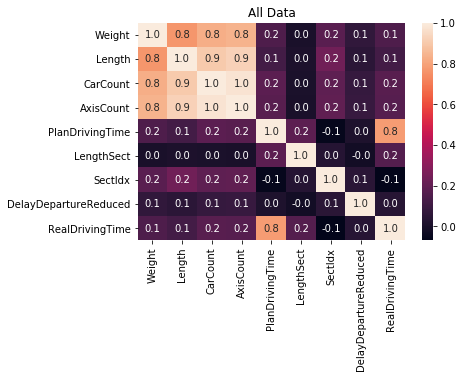

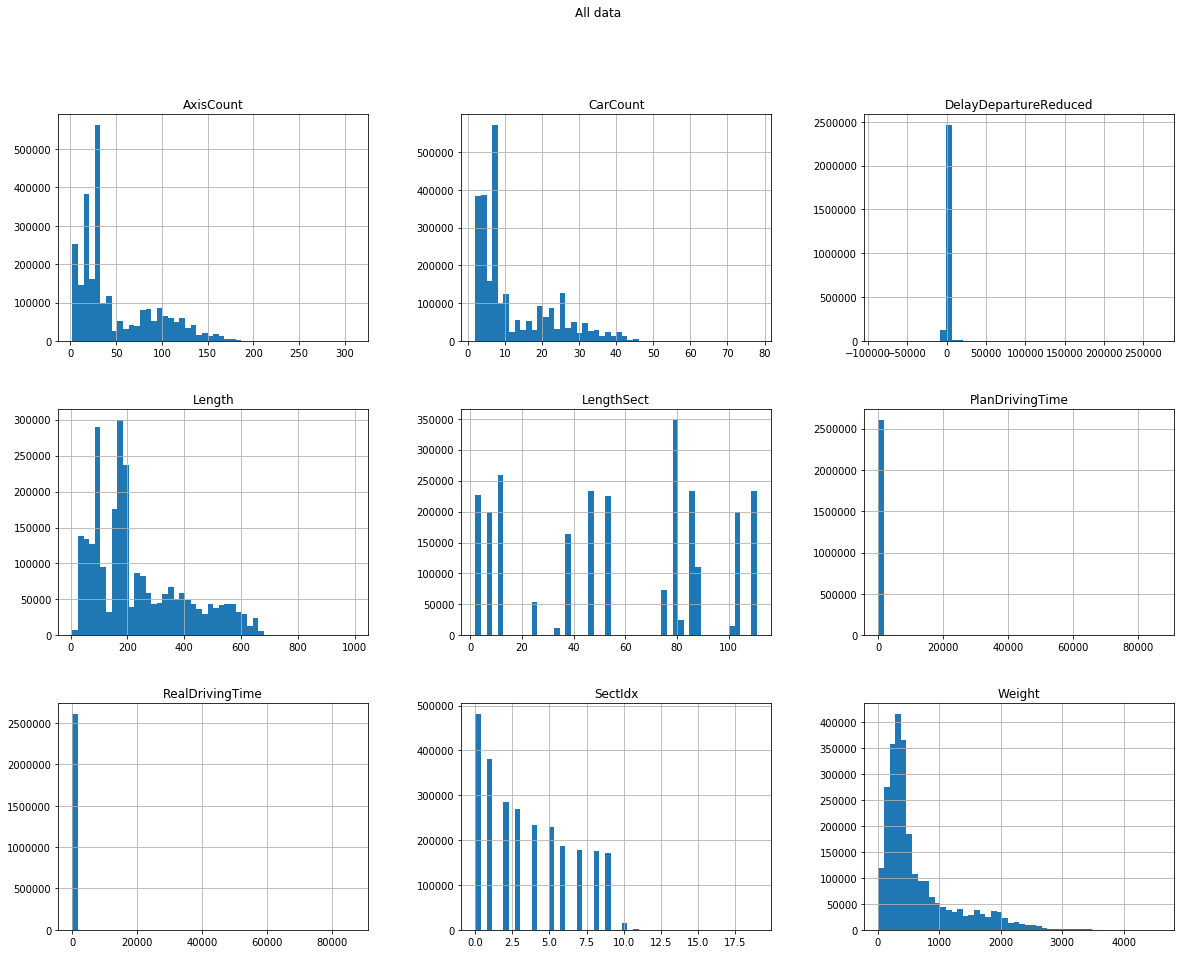

In [117]:
plt.title("All Data")
sns.heatmap(cor, annot = True, fmt='.1f')    
    
dffcut.hist(bins=50, figsize=(20, 15))
plt.suptitle("All data")
plt.show()

In [118]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(2086602, 8)
(521650, 8)


In [119]:
testModelReducedDelay = build_model(0.0001)


....................
....................
.........

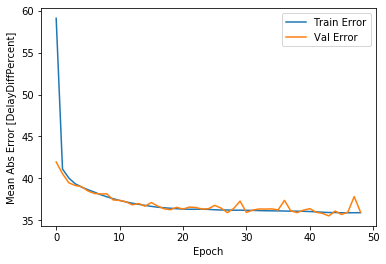

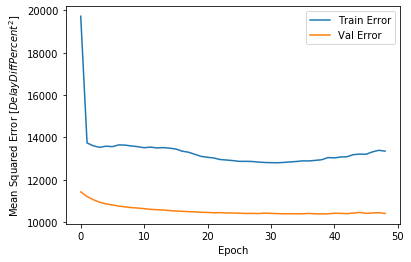

In [120]:
testModelReducedDelayHistory = testModelReducedDelay.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model("testModelReducedDelay2.h5"), PrintDot()])
plot_history(testModelReducedDelayHistory)

In [121]:
testModel = load_model("testModelReducedDelay2.h5")

# Vyhodnotenie

Pred Filtráciou jázd menších ako 5 hodín:

Tento model je oproti základnému modelu horší, takže ho ďalej nebudeme používať

max. chyby:
1579 sekúnd
-51678 sekúnd
# OPRAVIT
- Testing set Mean Abs Error: 35.49 RealDrivingTime
- Testing set Mean Sqrt Error: 15987.44 RealDrivingTime
- Testing set Root Mean Sqrt Error: 126.44 RealDrivingTime

Po Filtrácií
Samozdrejme, filtrácia veľkých jazdných dôb pomohla modelu, pretože sme sa zbavili nadbytočných dát. Ukazuje sa, že možno táto filtrácia nieje až tak potrebná

max chyby:
1332 sekúnd
-51693 sekúnd

- Testing set Mean Abs Error: 35.91 RealDrivingTime
- Testing set Mean Sqrt Error: 16268.83 RealDrivingTime
- Testing set Root Mean Sqrt Error: 127.55 RealDrivingTime



In [125]:
eval(testModel)

Testing set Loss : 16268.85 RealDrivingTime
Testing set Mean Abs Error: 35.91 RealDrivingTime
Testing set Mean Sqrt Error: 16268.83 RealDrivingTime
Testing set Root Mean Sqrt Error: 127.55 RealDrivingTime


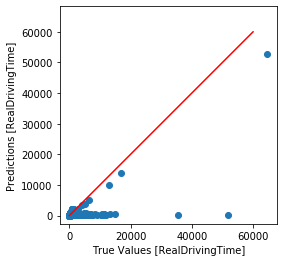

In [123]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [' + label + ']')
plt.ylabel('Predictions [' + label + ']')
plt.axis('equal')
plt.axis('square')

_ = plt.plot([0,60000],[0,60000],'r')
plt.show()

Chybu vypočítame ako rozdiel medzi hodnotami, ktoré model predpovedal a ozajstnými výsledkami.
Vídím, že histogram veľkosti chýb pripomína väčšinou gaussovu krivku a teda najčastejšie sa chyby pohybujú v rozdmedzí 2 minút od ozajstnej hodnoty.
Avšak model sa pomýlil v niektorých prípadoch až o polhodinu.
Štatistika ukazuje aj, že sa pomýlil takmer o 10 hodín. Toto môže byť prípadom nesprávneho záznamu.

Najväčšia chyba:1332.342041015625
Najväčšia chyba v zápornom smere:-51693.9921875
% chýb menších ako 2 minúty: 0.9559570593309691


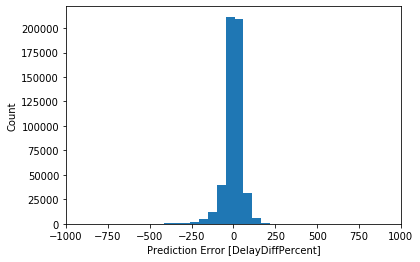

In [126]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

# Test 2 - sledovanie vplyvu typu vlaku na jazdnu dobu
V tomto teste sledujem, aký vplyv na presnosť modelu má vlastnosť typ vlaku.
Novými sledovanými vlastnosťami teda budú:
- Ex 
- Mn
- Nex
- Os 
- Pn
- R
- Sluz
- Sp
- Sv
- Vlec

Vynechané z databázy sú vlaky typu PMD a Lv ktoré v datasete neboli dostatočne zastúpené, a nepatria medzi vlaky osobnej alebo nákladnej dopravy

In [62]:
test2 = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
         'Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Sp', 'Sv', 'Vlec',
         'RealDrivingTime']

In [63]:
used_attributes = test2
label = used_attributes[-1]

In [278]:
nakladne = df[(df['TrainType'].isin(['Nex','Mn','Pn']))]
osobne = df[(df['TrainType'].isin(['Os','Ex','R']))]
ostatne = df[(df['TrainType'].isin(['Sluz','Sp','Sv','Vlec']))]

In [290]:
vlaky = []
for typ in train_types:
    vlaky.append(df[(df['TrainType'] == typ)])

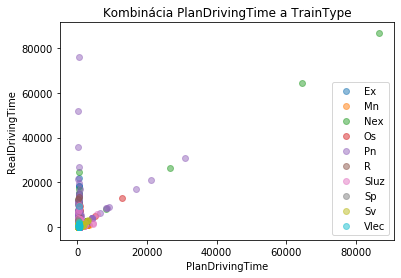

In [304]:
for vlak in vlaky:
    label = vlak['TrainType'].iat[0]
    plt.scatter(vlak['PlanDrivingTime'],vlak['RealDrivingTime'],alpha=0.5,label=label)

plt.ylabel("RealDrivingTime")
plt.xlabel("PlanDrivingTime")
plt.title("Kombinácia PlanDrivingTime a TrainType")
plt.legend()
plt.show()


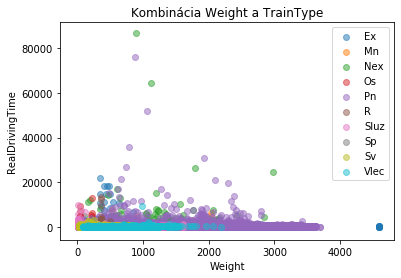

In [305]:
for vlak in vlaky:
    label = vlak['TrainType'].iat[0]
    plt.scatter(vlak['Weight'],vlak['RealDrivingTime'],alpha=0.5,label=label)

plt.ylabel("RealDrivingTime")
plt.xlabel("Weight")
plt.title("Kombinácia Weight a TrainType")
plt.legend()
plt.show()

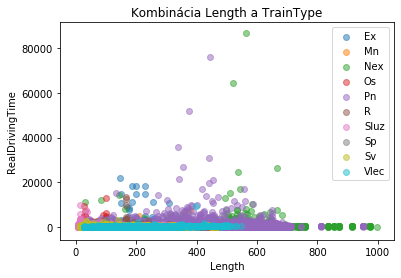

In [306]:
for vlak in vlaky:
    label = vlak['TrainType'].iat[0]
    plt.scatter(vlak['Length'],vlak['RealDrivingTime'],alpha=0.5,label=label)

plt.ylabel("RealDrivingTime")
plt.xlabel("Length")
plt.title("Kombinácia Length a TrainType")
plt.legend()
plt.show()

## One-Hot encoding
Typy vlakov získame z vlastnosti TrainType, ale keďže je hodnota kategorická a neordinálna, tak algoritmus strojového učenia s ňou nevie pracovať. Preto použijem techniku nazvanú one-hot encoding ktorá každému údaju pridá aj informáciu o tom, či daný vlak je alebo nieje daného typu

In [127]:
type = df['TrainType']
for train_type in train_types:
    df[train_type] = (type == train_type)*1.0

Najväčší lineárny plyv na meškanie má vlastnosť Ex, čo znamená, že vlaky Typu Ex mávajú menšie meškania ako iné vlaky. Podobný vlpyv májú aj vlaky typu R. 
Naopak väčšie meškania majú vlaky typu Pn, Os, Nex, Mn 

Avšak tieto korelácie sú veľmi slabé

In [128]:
cor_vlastnosti = train_types.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Lv', 'Sp', 'Sv', 'Vlec', 'RealDrivingTime']
RealDrivingTime    1.000000
Pn                 0.199324
Nex                0.079314
Mn                 0.059058
Sluz               0.044782
Os                 0.037285
Lv                 0.014358
Sv                 0.014240
Vlec               0.002648
Sp                -0.034576
R                 -0.093478
Ex                -0.228922
Name: RealDrivingTime, dtype: float64


Počet vlakov pre každý typ:
Ex: 731311
Mn: 11445
Nex: 350185
Os: 572389
Pn: 572569
R: 286270
Sluz: 15803
Lv: 24469
Sp: 20418
Sv: 21261
Vlec: 2132


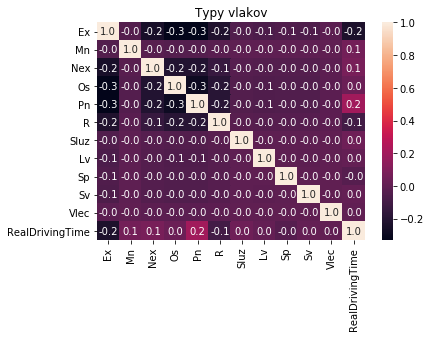

In [129]:
plt.title("Typy vlakov")
sns.heatmap(cor, annot = True, fmt='.1f')    

print("Počet vlakov pre každý typ:")
for typ_vlaku in train_types:
    print(typ_vlaku + ": " + str(len(df[(df[typ_vlaku] == 1.0)])))

Opäť rozdelíme dataset na trénovaciu a testovaciu časť a znormujeme hodnoty

In [130]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2086602, 8)
(521650, 8)
           count        mean          std           min         25%  \
count        8.0    8.000000     8.000000      8.000000    8.000000   
mean   2086602.0  180.655720   408.225278 -10833.375000   65.875000   
std          0.0  210.935881   777.984921  30684.255911  100.729393   
min    2086602.0    3.575013     2.927082 -86773.000000  -38.000000   
25%    2086602.0   39.513377    29.831651      1.500000    3.250000   
50%    2086602.0  102.450447   101.888429      2.000000   14.000000   
75%    2086602.0  256.146389   265.637316      6.500000  126.000000   
max    2086602.0  624.006427  2277.613200     86.000000  224.000000   

              50%         75%            max  
count    8.000000    8.000000       8.000000  
mean   122.625000  219.125000   45495.000000  
std    156.573066  260.992303   95977.284664  
min      0.000000    6.000000      19.000000  
25%      6.000000   65.000000     102.750000  
50%     40.500000   86.500000     654.000000  
75%   

In [139]:
test2Model = build_model(0.0001)


....................
....................
....................
....................

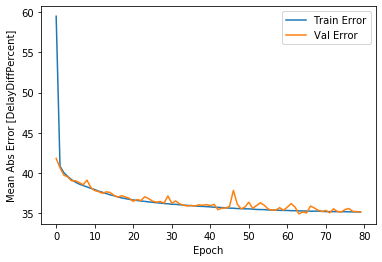

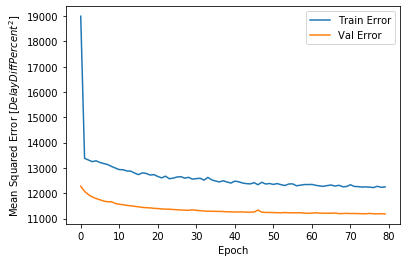

In [140]:
test2ModelFit = test2Model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, callbacks=[early_stop,save_best_model("Test2Model.h5"), PrintDot()])
plot_history(test2ModelFit)

In [141]:
testModel = load_model("Test2Model.h5")

## Vyhodnotenie

- Testing set Mean Abs Error: 35.05 RealDrivingTime
- Testing set Mean Sqrt Error: 15855.72 RealDrivingTime
- Testing set Root Mean Sqrt Error: 125.92 RealDrivingTime

In [142]:
eval(testModel)

Testing set Loss : 15855.70 RealDrivingTime
Testing set Mean Abs Error: 35.05 RealDrivingTime
Testing set Mean Sqrt Error: 15855.72 RealDrivingTime
Testing set Root Mean Sqrt Error: 125.92 RealDrivingTime


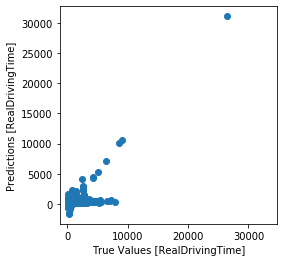

In [72]:
test_predictions = test2Model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [' + label + ']')
plt.ylabel('Predictions [' + label + ']')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:4605.896484375
Najväčšia chyba v zápornom smere:-7509.83642578125
% chýb menších ako 2 minúty: 0.9512963333135241


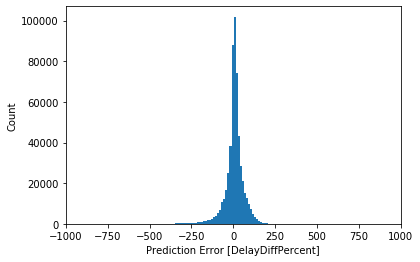

In [73]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

# Test 3 - vplyv ročných obodobí na jazdné doby vlakov
Podľa času výjazdu vlaku zo stanice som rozdelil dáta do štyroch skúpín 
- Jar 
- Leto
- Jeseň
- Zima

In [74]:
test3 = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
         'Jar', 'Leto', 'Jesen', 'Zima',
         'RealDrivingTime']

In [75]:
used_attributes = test3
label = used_attributes[-1]

In [76]:
season = df['Season']
for seas in season_types:
    df[seas] = (season == seas)*1.0

In [77]:
cor_vlastnosti = season_types.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Jar', 'Leto', 'Jesen', 'Zima', 'RealDrivingTime']
RealDrivingTime    1.000000
Jesen              0.013461
Jar               -0.000755
Leto              -0.004730
Zima              -0.009104
Name: RealDrivingTime, dtype: float64


Korelačná matica ukazuje, že ročné obodbie nemá žiadny zaznamenateľný vplyv na jazdnú dobu vlaku. Toto môže viesť k dvom prípadom. Buď model prestane byť senzitívny na isté neuróny, alebo sa naučí zle, čím by sme mohli získať nepresnosť vo predikciách

Počet vlakov pre každú sezónu:
Jar: 699891
Leto: 805512
Jesen: 760129
Zima: 510951


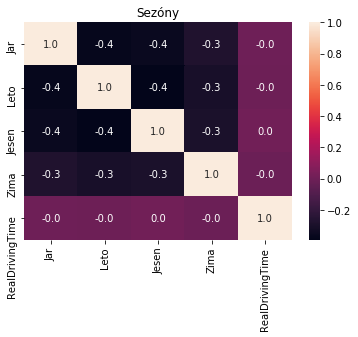

In [78]:
plt.title("Sezóny")
sns.heatmap(cor, annot = True, fmt='.1f')    

print("Počet vlakov pre každú sezónu:")
for roc_obd in season_types:
    print(roc_obd + ": " + str(len(df[(df[roc_obd] == 1.0)])))

Opäť rozdelíme dataset na trénovaciu a testovaciu časť a znormujeme hodnoty

In [79]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 12)
(555297, 12)
           count         mean           std           min         25%  \
count       12.0    12.000000     12.000000  1.200000e+01   12.000000   
mean   2221186.0   436.211372   1338.923434 -1.872772e+05   50.166667   
std          0.0  1130.852438   4327.983870  6.487767e+05   82.828227   
min    2221186.0     0.183892      0.387396 -2.247420e+06    0.000000   
25%    2221186.0     0.286038      0.451842  0.000000e+00    0.000000   
50%    2221186.0    28.792309     23.336708  5.000000e-01    8.000000   
75%    2221186.0   248.517503    165.900374  1.250000e+00   52.250000   
max    2221186.0  3980.299966  15072.411286  8.600000e+01  224.000000   

              50%          75%           max  
count   12.000000    12.000000  1.200000e+01  
mean    99.750000   232.333333  2.196969e+05  
std    140.061756   371.846824  7.322330e+05  
min      0.000000     0.000000  1.000000e+00  
25%      0.000000     1.000000  1.000000e+00  
50%     17.500000    47.500000  9

In [80]:
test3Model = build_model()
print(test3Model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                832       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
test3ModelFit = test3Model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


..........................

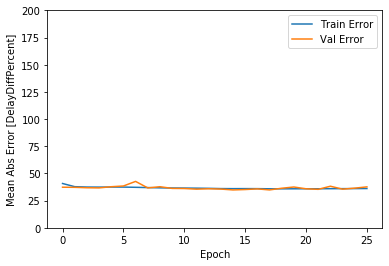

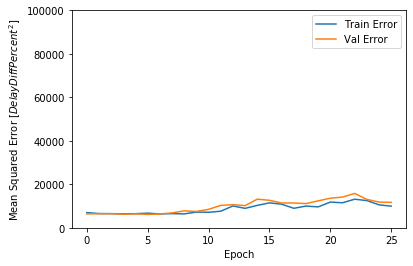

In [82]:
plot_history(test3ModelFit)

In [83]:
eval(test3Model)

Testing set Loss : 6946.11 RealDrivingTime
Testing set Mean Abs Error: 37.69 RealDrivingTime
Testing set Mean Sqrt Error: 6946.12 RealDrivingTime
Testing set Root Mean Sqrt Error: 83.34 RealDrivingTime


## Vyhodnotenie
Vidím, že ročné obdobie neprospieva modelu, a naopak, jeho vplyv práve zhoršuje presnosť modelu.

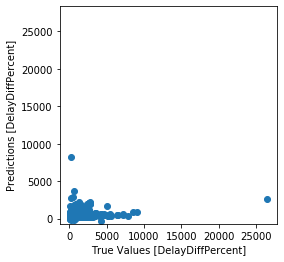

In [84]:
test_predictions = test3Model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:7920.373046875
Najväčšia chyba v zápornom smere:-23816.380859375
% chýb menších ako 2 minúty: 0.955540908738927


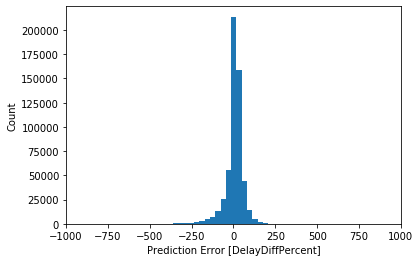

In [85]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

# Test 4 - vplyv obdobia dňa na jazdné doby 
Predpokladám, že vlaky v čase rána častejšie meškajú práve pre väčší počet spojov a cestujúcich. Do modelu pridávam vlastnosti
- Ráno
- Obed
- Večer
- Noc

In [86]:
test4 = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
         'Rano', 'Obed', 'Vecer', 'Noc',
         'RealDrivingTime']

In [87]:
used_attributes = test4
label = used_attributes[-1]

In [88]:
type = df['DayTime']
for daytime in daytime_types:
    df[daytime] = (type == daytime)*1.0

Obdobie dňa má minimálny linárny vplyv na jazdnú dobu.

In [89]:
cor_vlastnosti = daytime_types.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Rano', 'Obed', 'Vecer', 'Noc', 'RealDrivingTime']
RealDrivingTime    1.000000
Noc                0.056691
Rano              -0.001550
Vecer             -0.020119
Obed              -0.025551
Name: RealDrivingTime, dtype: float64


Počet vlakov pre každé obdobie:
Rano: 721541
Obed: 793190
Vecer: 789584
Noc: 472168


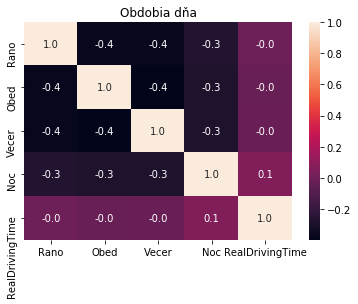

In [90]:
plt.title("Obdobia dňa")
sns.heatmap(cor, annot = True, fmt='.1f')    

print("Počet vlakov pre každé obdobie:")
for obdobie in daytime_types:
    print(obdobie + ": " + str(len(df[(df[obdobie] == 1.0)])))

In [91]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 12)
(555297, 12)
           count         mean           std           min         25%  \
count       12.0    12.000000     12.000000  1.200000e+01   12.000000   
mean   2221186.0   436.211372   1338.923075 -1.872772e+05   50.166667   
std          0.0  1130.852438   4327.983991  6.487767e+05   82.828227   
min    2221186.0     0.169953      0.375592 -2.247420e+06    0.000000   
25%    2221186.0     0.285415      0.451611  0.000000e+00    0.000000   
50%    2221186.0    28.792309     23.336708  5.000000e-01    8.000000   
75%    2221186.0   248.517503    165.900374  1.250000e+00   52.250000   
max    2221186.0  3980.299966  15072.411286  8.600000e+01  224.000000   

              50%          75%           max  
count   12.000000    12.000000  1.200000e+01  
mean    99.750000   232.333333  2.196969e+05  
std    140.061756   371.846824  7.322330e+05  
min      0.000000     0.000000  1.000000e+00  
25%      0.000000     1.000000  1.000000e+00  
50%     17.500000    47.500000  9

In [92]:
test4Model = build_model()
print(test4Model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________
None


In [93]:
test4ModelFit = test4Model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


......................

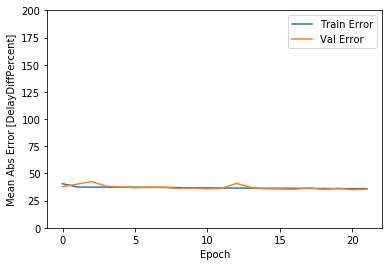

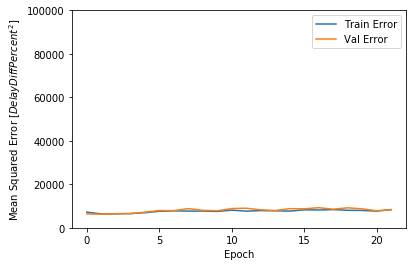

In [94]:
plot_history(test4ModelFit)

In [95]:
eval(test4Model)

Testing set Loss : 5955.32 RealDrivingTime
Testing set Mean Abs Error: 35.65 RealDrivingTime
Testing set Mean Sqrt Error: 5955.31 RealDrivingTime
Testing set Root Mean Sqrt Error: 77.17 RealDrivingTime


## Vyhodnotenie
Vidím, že ročné obdobie neprospieva modelu, a naopak, jeho vplyv práve zhoršuje presnosť modelu.

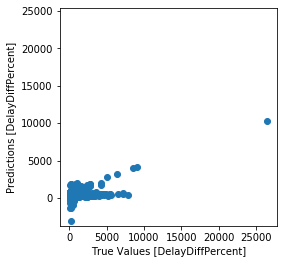

In [96]:
test_predictions = test4Model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:1588.075439453125
Najväčšia chyba v zápornom smere:-16140.400390625
% chýb menších ako 2 minúty: 0.9538589259441344


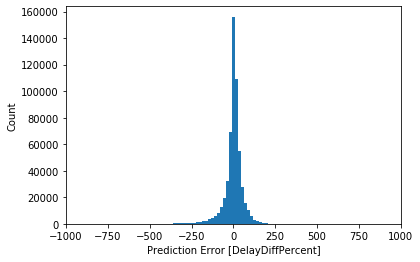

In [97]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

# Úvaha
Uvedomujem si, že nejväčším vplyvom na reálnu jazdnú dobu má práve plánovaná doba trasy, keďže v ideálnom prípade, sa reálna jazdná doba zhoduje s plánovanou. Vtedy môže nastať situácia, že model bude odhadovať jazdnú dobu iba tým, že vyhlási, že úsek nemá žiadne meškanie, a štatistiky modelu by preukázali, že tento model nieje veľmi nepresný. Preto ak chcem skúmať vplyv vlastností ako ročné obdobie, alebo obdobie dňa tak sa musím sledovať inú premennú. Na začiatok by sme mali sledovať vplyv vlastností na meškanie, ktoré vypočítame ako RealDrivingTime - PlanDrivingTime. Už teraz tuším, že najväčší vplyv na veľkosť meškania bude mať časová dĺžka trasy, pretože na dhlších tratiach sa meškania akumulujú rýchlejšie. Preto našu sledovanú premennú uvediem ako pomer meškania k časovej dĺžke trasy. Pri vypočítaní týchto meškaní potom jednoducho získame jazdné doby vynásobením premennou PlanDrivingTime a jej pripočítaním. 

- DelayDiff = Rozdiel medzi reálnym trvaním trasy a plánovaným trvaním trasy
    - DelayDiff = RealDrivingTime - PlanDrivingTime
- DelayDiffPercent = podiel meškania ku plánovanému časovému trvaniu trasy
    - DelayDiffPercent = DelayDiff / PlanDrivingTime

In [40]:
def getDrivingTime(a,b):  
    return a * b + b

# Test 1 Alternatíva skúmanie vplyvu parametrov vlaku na jeho meškanie v pomere k plánovanému trvaniu trasy

In [49]:
test1Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture',
         'DelayDiffPercent']

In [50]:
used_attributes = test1Alt
label = used_attributes[-1]

koreláčná matica ukazuje veľmi malý lineárny vplyv atribútov na meškanie.

In [51]:
print(used_attributes)
dffcut = df[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDeparture', 'DelayDiffPercent']
DelayDiffPercent    1.000000
CarCount            0.071952
AxisCount           0.070630
Weight              0.069227
Length              0.062288
DelayDeparture      0.043824
LengthSect          0.002520
SectIdx            -0.069227
PlanDrivingTime    -0.113058
Name: DelayDiffPercent, dtype: float64


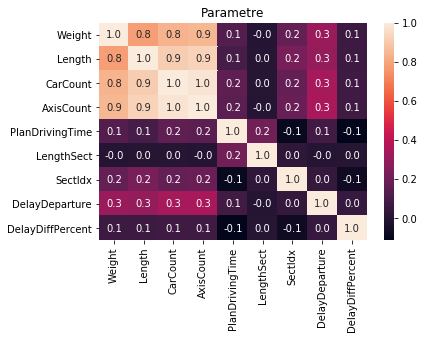

In [52]:
plt.title("Parametre")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [53]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset) 

(2221186, 8)
(555297, 8)


In [54]:
test1AltModel = build_model()
print(test1AltModel.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
test1AltModelFit = test1AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


......................

In [36]:
def plot_history_Percent(history, train_PlanDrivingTime):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [' + label + ']')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    plt.legend()
    plt.ylim([0, 1])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [$' + label + '^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    plt.legend()
    plt.ylim([0, 1])

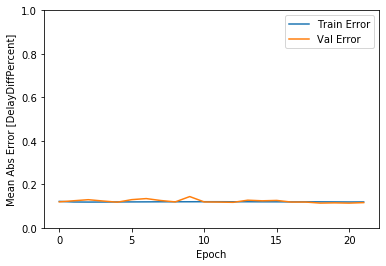

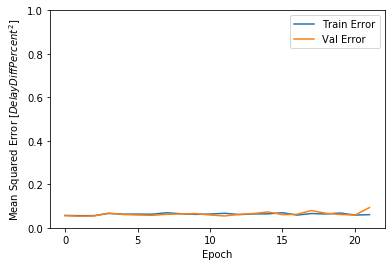

In [57]:
plot_history_Percent(test1AltModelFit, train_dataset['PlanDrivingTime'])

Použijem upravenú metódu eval ktorá prevedie meškanie na reálnu jazdnú dobu. 

In [44]:
import math
def eval_Percent(errors):
    
    # mae
    mae = sum(abs(errors)) / len(errors)
    print("MAE:")
    print(mae)
    # mse, loss 
    mse = sum(np.square(errors)) / len(errors)
    print("MSE:")
    print(mse)
    # RMSE 
    rmse = math.sqrt(mse)
    print("RMSE:")  
    print(rmse)

## Vyhodnotenie
Vidím, že sledovanie novej premennej zatiaľ základnému modelu nijak nepomohol. Keď sa pozriem na vlastnosti úsekov v ktorých sa model najviac zmýlil, tak vídím, že vlastnosť ktorá výrazne vyčnieva od ostatných je doterajšie meškani v sekundách. Model sa snaží generalizovať, a preto pri vysokých doterajších meškaniach lineárne zvyšuje meškanie. Preto túto vlastnosť odstánime.

In [59]:
test_predictions = test1AltModel.predict(normed_test_data).flatten()

In [60]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [61]:
errors = inter - inter_real

In [62]:
eval_Percent(errors.values)

MAE:
37.22108314366366
MSE:
921196.8385197944
RMSE:
959.7899970930071


In [65]:
eval(test1AltModel)

Testing set Loss :  0.07 RealDrivingTime
Testing set Mean Abs Error:  0.12 RealDrivingTime
Testing set Mean Sqrt Error:  0.07 RealDrivingTime
Testing set Root Mean Sqrt Error:  0.26 RealDrivingTime


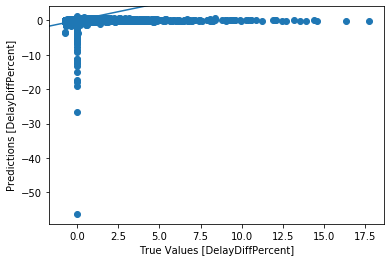

In [66]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

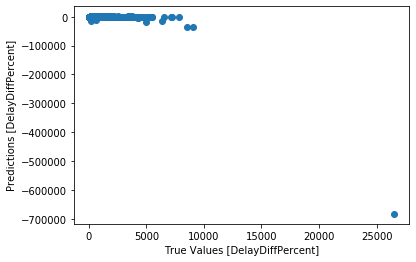

In [67]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

In [68]:
big = errors[(abs(errors.values) > 3000)]

In [69]:
for key, value in big.items():
    print("Odhad: " + str(inter[key]),"Planovana hodnota: " + str(test_dataset['PlanDrivingTime'][key]), "Realna hodnota: " + str(test_dataset['PlanDrivingTime'][key] * test_labels[key] + test_dataset['PlanDrivingTime'][key]))
    print(test_dataset.loc[key])
    print("\n")
    

Odhad: -1312.0093 Planovana hodnota: 2610 Realna hodnota: 2610.0
Weight               85.0
Length               18.0
CarCount              1.0
AxisCount             4.0
PlanDrivingTime    2610.0
LengthSect           33.0
SectIdx               0.0
DelayDeparture     9540.0
Name: 210173, dtype: float64


Odhad: -2297.6323 Planovana hodnota: 2610 Realna hodnota: 2610.0
Weight               614.0
Length               331.0
CarCount              17.0
AxisCount             68.0
PlanDrivingTime     2610.0
LengthSect            33.0
SectIdx                0.0
DelayDeparture     41100.0
Name: 213102, dtype: float64


Odhad: -2345.2236 Planovana hodnota: 2610 Realna hodnota: 2610.0
Weight              1314.0
Length               322.0
CarCount              17.0
AxisCount             68.0
PlanDrivingTime     2610.0
LengthSect            33.0
SectIdx                0.0
DelayDeparture     40380.0
Name: 216922, dtype: float64


Odhad: 526.7746 Planovana hodnota: 480 Realna hodnota: 4054.0
Weight    

Najväčšia chyba:617.975341796875
Najväčšia chyba v zápornom smere:-708795.6875
% chýb menších ako 2 minúty: 0.9502104279331601


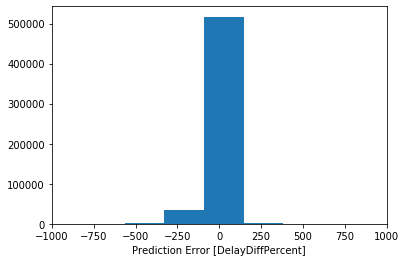

In [70]:
#error = test_predictions - test_labels
error = errors.values

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=3000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
plt.show()
#_ = plt.ylabel("Count")

# Upravený Alternatívny Test 1 - bez doterajšieho meškania v sekundách
- Očakávam, že vyradenie tohoto atribútu aspoň trochu pomôže presnosti modelu, ktorý už nebude pri veľkých doterajších meškaniach ukazovať veľkú chybu

In [71]:
test1Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 
         'DelayDiffPercent']

In [72]:
used_attributes = test1Alt
label = used_attributes[-1]

koreláčná matica ukazuje veľmi malý lineárny vplyv atribútov na meškanie.

In [73]:
print(used_attributes)
dffcut = df[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx', 'DelayDiffPercent']
DelayDiffPercent    1.000000
CarCount            0.071952
AxisCount           0.070630
Weight              0.069227
Length              0.062288
LengthSect          0.002520
SectIdx            -0.069227
PlanDrivingTime    -0.113058
Name: DelayDiffPercent, dtype: float64


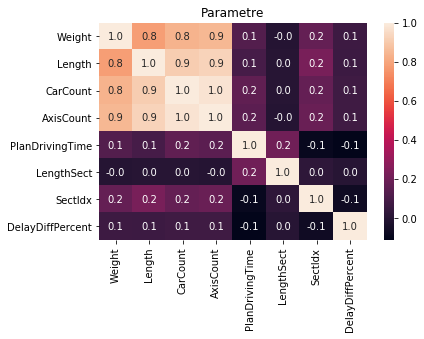

In [74]:
plt.title("Parametre")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [75]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset) 

(2221186, 7)
(555297, 7)


In [77]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

In [78]:
test1AltModel = build_model()
print(test1AltModel.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
test1AltModelFit = test1AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


....................................

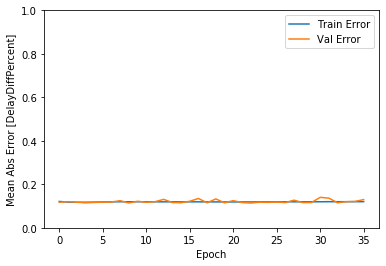

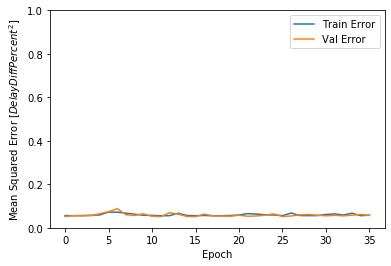

In [80]:
plot_history_Percent(test1AltModelFit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie
Vyradenie DelayDeparture výrazne pomohlo, ale stále môj model neukazuje lepšie výsledky ako pôvodný model. Skúsim teda zaviesť filtre ktoré som použil na pôvodnom modeli a uvidím rozdiel vo vplyve.

In [81]:
test_predictions = test1AltModel.predict(normed_test_data).flatten()

In [82]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [83]:
errors = inter - inter_real

In [84]:
eval_Percent(errors.values)

MAE:
40.42120938860817
MSE:
28295.679654110936
RMSE:
168.213197027198


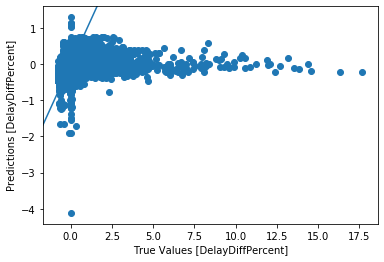

In [85]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

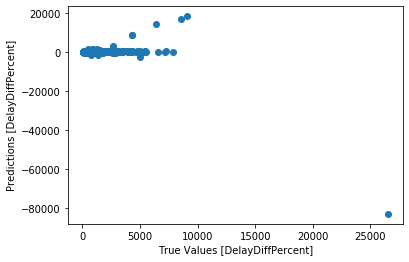

In [86]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

In [87]:
big = errors[(abs(errors.values) > 3000)]

In [88]:
for key, value in big.items():
    print("Odhad: " + str(inter[key]),"Planovana hodnota: " + str(test_dataset['PlanDrivingTime'][key]), "Realna hodnota: " + str(test_dataset['PlanDrivingTime'][key] * test_labels[key] + test_dataset['PlanDrivingTime'][key]))
    print(test_dataset.loc[key])
    print("\n")
    

Odhad: -534.05054 Planovana hodnota: 2610 Realna hodnota: 2610.0
Weight               85.0
Length               18.0
CarCount              1.0
AxisCount             4.0
PlanDrivingTime    2610.0
LengthSect           33.0
SectIdx               0.0
Name: 210173, dtype: float64


Odhad: 496.5259 Planovana hodnota: 480 Realna hodnota: 4054.0
Weight             1561.0
Length              326.0
CarCount             21.0
AxisCount            84.0
PlanDrivingTime     480.0
LengthSect            7.0
SectIdx               4.0
Name: 266877, dtype: float64


Odhad: 470.53848 Planovana hodnota: 540 Realna hodnota: 3995.0
Weight             555.0
Length             199.0
CarCount            15.0
AxisCount           48.0
PlanDrivingTime    540.0
LengthSect           7.0
SectIdx              5.0
Name: 267594, dtype: float64


Odhad: -536.8152 Planovana hodnota: 2610 Realna hodnota: 2610.0
Weight               88.0
Length               17.0
CarCount              1.0
AxisCount             4.0
PlanDrivin

Najväčšia chyba:9535.3203125
Najväčšia chyba v zápornom smere:-109389.4921875
% chýb menších ako 2 minúty: 0.9477180679888421


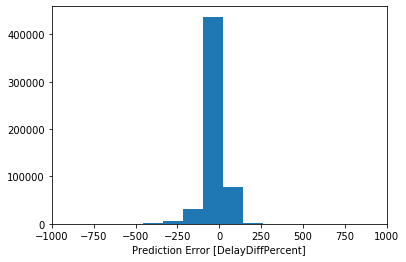

In [89]:
#error = test_predictions - test_labels
error = errors.values

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
plt.show()
#_ = plt.ylabel("Count")

# Test 2 Alternatíva - skúmanie vplyvu typu vlaku na percento meškania


In [90]:
test2Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
         'Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Sp', 'Sv', 'Vlec',
         'DelayDiffPercent']

In [91]:
used_attributes = test2Alt
label = used_attributes[-1]

Vidím, že teraz majú jednotlivé typy nižšiu koreláciu, čo je však v poriadku. V predošlých pokusoch vyššia korelácia znamenala, že isté typy vlakov majú dlhšie reálne jazdné doby, čo môže znamenať to, že aj ich plánované jazdné doby sú dlhé. Napríklad nákladné vlaky a rýchliky ukazovali vyššiu koreláciu, pretože nákladné vlaky jazdia často dlhé trate bez zastávok, zatiaľ čo rýchliky sú rýchlejšie a majú v trase mnoho zastávok. Teraz model ukazuje vplyv typu vlaku na meškanie a vidím, že nákladné vlaky na svojej trase viac meškajú ako iné vlaky. Naopak rýchliky a expresy málokedy meškajú.

In [92]:
type = df['TrainType']
for train_type in train_types:
    df[train_type] = (type == train_type)*1.0

In [93]:
cor_vlastnosti = train_types.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Ex', 'Mn', 'Nex', 'Os', 'Pn', 'R', 'Sluz', 'Sp', 'Sv', 'Vlec', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Pn                  0.065619
Os                  0.019558
Sluz                0.008031
Nex                 0.004540
Sv                 -0.004536
Sp                 -0.005439
Mn                 -0.017532
Vlec               -0.033671
Ex                 -0.040693
R                  -0.050080
Name: DelayDiffPercent, dtype: float64


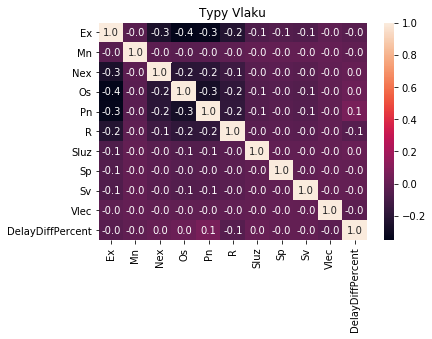

In [94]:
plt.title("Typy Vlaku")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [95]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 17)
(555297, 17)
           count        mean         std        min         25%         50%  \
count       17.0   17.000000   17.000000  17.000000   17.000000   17.000000   
mean   2221186.0   73.778618   58.545193   5.470588   33.235294   56.294118   
std          0.0  161.078441  142.001233  20.763904   73.109105  118.246969   
min    2221186.0    0.000952    0.030843   0.000000    0.000000    0.000000   
25%    2221186.0    0.012555    0.111342   0.000000    0.000000    0.000000   
50%    2221186.0    0.219984    0.414235   0.000000    0.000000    0.000000   
75%    2221186.0   46.146443   36.411201   1.000000   12.000000   28.000000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count   17.000000     17.000000  
mean    94.882353   5462.000000  
std    199.959334  20979.582792  
min      0.000000      1.000000  
25%      0.000000      1.000000  
50%      0.000000      1.000000  
75%     76.000000    11

In [96]:
test2AltModel = build_model()
print(test2AltModel.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
test2AltModelFit = test2AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


.................................

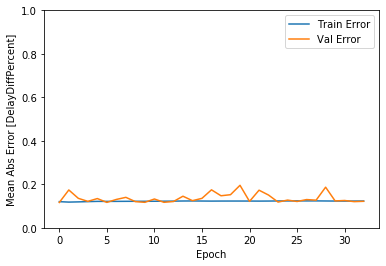

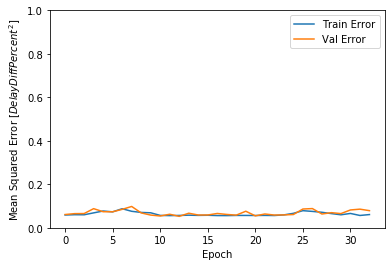

In [98]:
plot_history_Percent(test2AltModelFit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [99]:
test_predictions = test2AltModel.predict(normed_test_data).flatten()

In [100]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [101]:
errors = inter - inter_real

In [102]:
eval_Percent(errors)

MAE:
40.46055956016179
MSE:
2426557.7501240005
RMSE:
1557.741233364515


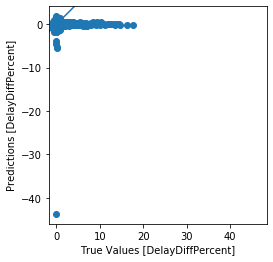

In [103]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

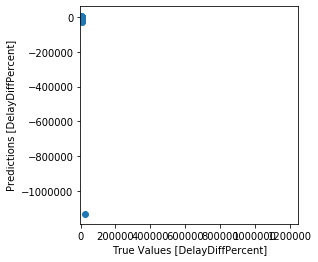

In [104]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:1484.97998046875
Najväčšia chyba v zápornom smere:-1157913.5
% chýb menších ako 2 minúty: 0.9471562064985044


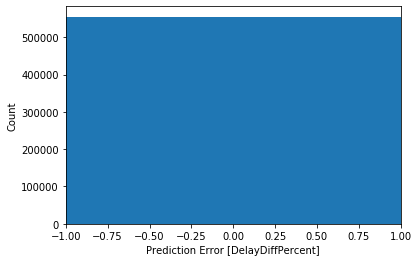

In [105]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1,1])
_ = plt.ylabel("Count")

# Test 3 Alternatíva - skúmanie vplyvu ročného obdobia na percento meškania


In [106]:
test3Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
         'Jar','Leto', 'Jesen', 'Zima',
         'DelayDiffPercent']

In [107]:
used_attributes = test3Alt
label = used_attributes[-1]

Vidím, že teraz majú jednotlivé typy nižšiu koreláciu, čo je však v poriadku. V predošlých pokusoch vyššia korelácia znamenala, že isté typy vlakov majú dlhšie reálne jazdné doby, čo môže znamenať to, že aj ich plánované jazdné doby sú dlhé. Napríklad nákladné vlaky a rýchliky ukazovali vyššiu koreláciu, pretože nákladné vlaky jazdia často dlhé trate bez zastávok, zatiaľ čo rýchliky sú rýchlejšie a majú v trase mnoho zastávok. Teraz model ukazuje vplyv typu vlaku na meškanie a vidím, že nákladné vlaky na svojej trase viac meškajú ako iné vlaky. Naopak rýchliky a expresy málokedy meškajú.

In [108]:
type = df['Season']
for season_type in season_types:
    df[season_type] = (type == season_type)*1.0

In [109]:
cor_vlastnosti = season_types.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Jar', 'Leto', 'Jesen', 'Zima', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Jesen               0.021465
Jar                -0.005363
Leto               -0.007009
Zima               -0.010482
Name: DelayDiffPercent, dtype: float64


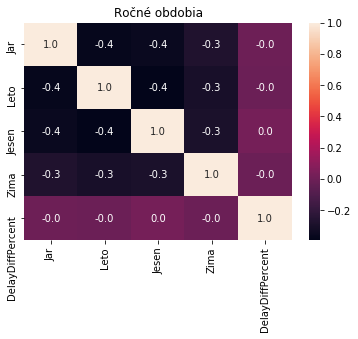

In [110]:
plt.title("Ročné obdobia")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [111]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 11)
(555297, 11)
           count        mean         std        min         25%         50%  \
count       11.0   11.000000   11.000000  11.000000   11.000000   11.000000   
mean   2221186.0  114.021500   90.424539   8.454545   51.363636   87.000000   
std          0.0  190.962347  170.574078  25.730774   86.762057  139.403013   
min    2221186.0    0.183892    0.387396   0.000000    0.000000    0.000000   
25%    2221186.0    0.282046    0.449908   0.000000    0.000000    0.000000   
50%    2221186.0   11.438174   10.262214   1.000000    4.000000    7.000000   
75%    2221186.0  141.444981  102.793034   1.500000   57.000000  113.500000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count   11.000000     11.000000  
mean   146.818182   8440.727273  
std    235.727732  26011.055731  
min      0.000000      1.000000  
25%      1.000000      1.000000  
50%     19.000000     78.000000  
75%    208.000000    64

In [112]:
test3AltModel = build_model()
print(test3AltModel.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                768       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________
None


In [113]:
test3AltModelFit = test3AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


...............................

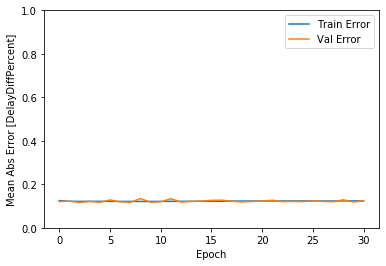

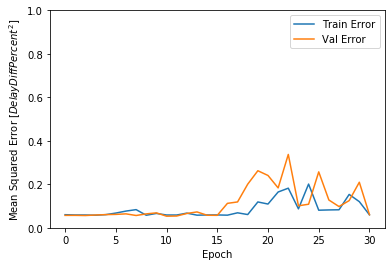

In [114]:
plot_history_Percent(test3AltModelFit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [115]:
test_predictions = test3AltModel.predict(normed_test_data).flatten()

In [116]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [117]:
errors = inter - inter_real

In [118]:
eval_Percent(errors)

MAE:
39.65405120903742
MSE:
314273.0469448312
RMSE:
560.600612686814


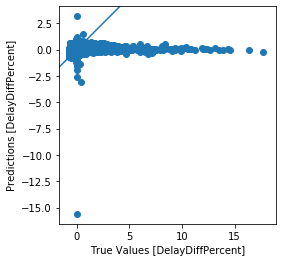

In [119]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

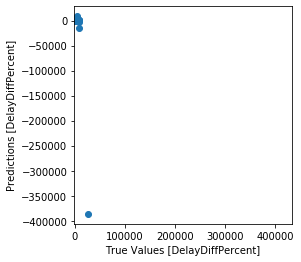

In [120]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:3632.3544921875
Najväčšia chyba v zápornom smere:-412940.71875
% chýb menších ako 2 minúty: 0.944622427277655


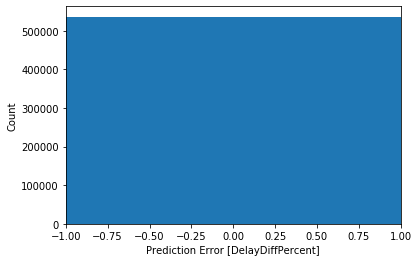

In [121]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1,1])
_ = plt.ylabel("Count")

# Test 4 Alternatíva - skúmanie vplyvu obdobia dňa na percento meškania


In [122]:
test4Alt = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
         'Rano', 'Obed', 'Vecer', 'Noc',
         'DelayDiffPercent']

In [123]:
used_attributes = test4Alt
label = used_attributes[-1]

Vidím, že teraz majú jednotlivé typy nižšiu koreláciu, čo je však v poriadku. V predošlých pokusoch vyššia korelácia znamenala, že isté typy vlakov majú dlhšie reálne jazdné doby, čo môže znamenať to, že aj ich plánované jazdné doby sú dlhé. Napríklad nákladné vlaky a rýchliky ukazovali vyššiu koreláciu, pretože nákladné vlaky jazdia často dlhé trate bez zastávok, zatiaľ čo rýchliky sú rýchlejšie a majú v trase mnoho zastávok. Teraz model ukazuje vplyv typu vlaku na meškanie a vidím, že nákladné vlaky na svojej trase viac meškajú ako iné vlaky. Naopak rýchliky a expresy málokedy meškajú.

In [124]:
type = df['DayTime']
for daytime_type in daytime_types:
    df[daytime_type] = (type == daytime_type)*1.0

In [125]:
cor_vlastnosti = daytime_types.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Rano', 'Obed', 'Vecer', 'Noc', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Rano                0.007800
Obed                0.001822
Vecer              -0.003652
Noc                -0.006911
Name: DelayDiffPercent, dtype: float64


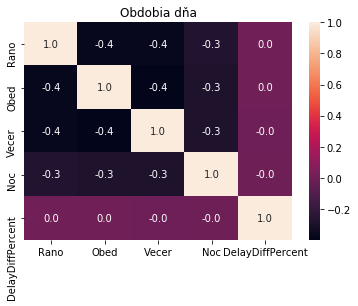

In [126]:
plt.title("Obdobia dňa")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [127]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 11)
(555297, 11)
           count        mean         std        min         25%         50%  \
count       11.0   11.000000   11.000000  11.000000   11.000000   11.000000   
mean   2221186.0  114.021500   90.424147   8.454545   51.363636   87.000000   
std          0.0  190.962347  170.574306  25.730774   86.762057  139.403013   
min    2221186.0    0.169953    0.375592   0.000000    0.000000    0.000000   
25%    2221186.0    0.285018    0.451422   0.000000    0.000000    0.000000   
50%    2221186.0   11.438174   10.262214   1.000000    4.000000    7.000000   
75%    2221186.0  141.444981  102.793034   1.500000   57.000000  113.500000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count   11.000000     11.000000  
mean   146.818182   8440.727273  
std    235.727732  26011.055731  
min      0.000000      1.000000  
25%      1.000000      1.000000  
50%     19.000000     78.000000  
75%    208.000000    64

In [128]:
test4AltModel = build_model()
print(test4AltModel.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                768       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________
None


In [129]:
test4AltModelFit = test4AltModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


.......................

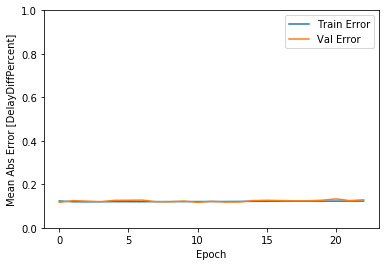

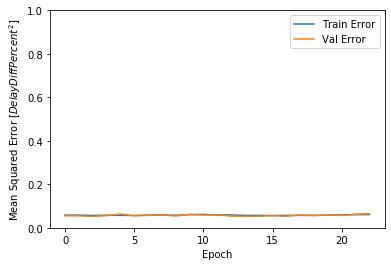

In [130]:
plot_history_Percent(test4AltModelFit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [132]:
test_predictions = test4AltModel.predict(normed_test_data).flatten()

In [133]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [134]:
errors = inter - inter_real

In [135]:
eval_Percent(errors)

MAE:
41.52294867912508
MSE:
1053482.923705676
RMSE:
1026.3931623435906


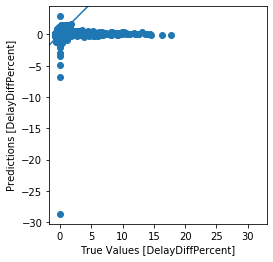

In [136]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

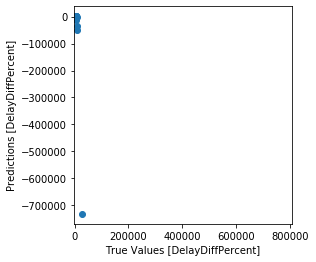

In [137]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:1035.176513671875
Najväčšia chyba v zápornom smere:-758740.25
% chýb menších ako 2 minúty: 0.9454922320848123


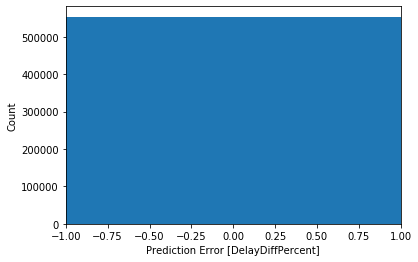

In [138]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1,1])
_ = plt.ylabel("Count")

# Pridanie predošlých meškaní do modelu
Očakávam, že pridaním predošlých meškaní, bude model môcť využiť časový rad pre zlepšenie presnosti. Avšak bude mať obmedzenia z pohľadu úsekov, ktoré sú na začiatku trasy a teda nemajú predošlé meškanie.

In [28]:
casovy_rad = ['Ar1', 'Ar2', 'Ar3', 'Ar4', 'Ar5', 'Ar6', 'Ar7', 'Ar8', 'Ar9']
testCasovyRad = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
                 'Ar1', 'Ar2', 'Ar3', 'Ar4', 'Ar5', 'Ar6', 'Ar7', 'Ar8', 'Ar9', 
                 'DelayDiffPercent']

In [29]:
used_attributes = testCasovyRad
label = used_attributes[-1]

In [30]:
cor_vlastnosti = casovy_rad.copy()
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Ar1', 'Ar2', 'Ar3', 'Ar4', 'Ar5', 'Ar6', 'Ar7', 'Ar8', 'Ar9', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Ar1                 0.160644
Ar2                 0.054488
Ar3                 0.045771
Ar4                 0.022079
Ar6                 0.017665
Ar5                 0.014066
Ar8                 0.012634
Ar7                 0.008600
Ar9                -0.001929
Name: DelayDiffPercent, dtype: float64


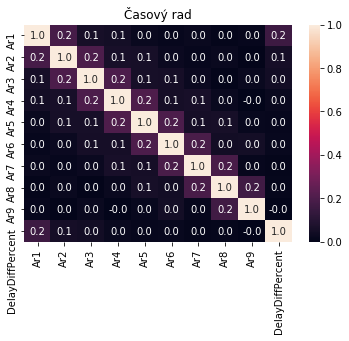

In [31]:
plt.title("Časový rad")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [32]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 16)
(555297, 16)
           count        mean         std        min         25%         50%  \
count       16.0   16.000000   16.000000  16.000000   16.000000   16.000000   
mean   2221186.0   78.332688   62.154619   5.398004   35.300099   59.812500   
std          0.0  165.227054  145.850636  21.518478   74.993094  121.202431   
min    2221186.0    0.007300    0.097431  -0.746032   -0.083333    0.000000   
25%    2221186.0    0.009922    0.167936  -0.741667   -0.001389    0.000000   
50%    2221186.0    0.011951    0.228012  -0.717949    0.000000    0.000000   
75%    2221186.0   48.908031   37.620664   1.000000   13.000000   34.250000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count   16.000000     16.000000  
mean   100.753971   5812.442448  
std    204.997919  21616.206463  
min      0.000000     15.950000  
25%      0.000000     17.100000  
50%      0.031766     18.382639  
75%     78.250000    16

In [33]:
testCasovyRadModel = build_model()
print(testCasovyRadModel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
testCasovyRadFit = testCasovyRadModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


.......................

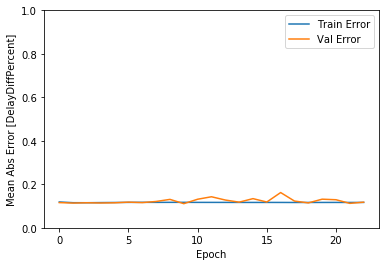

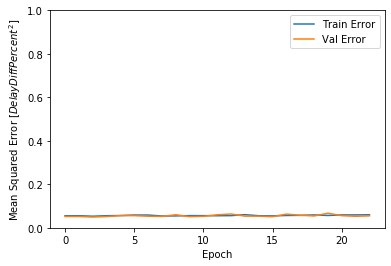

In [37]:
plot_history_Percent(testCasovyRadFit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [38]:
test_predictions = testCasovyRadModel.predict(normed_test_data).flatten()

In [41]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [42]:
errors = inter - inter_real

In [45]:
eval_Percent(errors)

MAE:
36.67511922299004
MSE:
203050.12192479693
RMSE:
450.61083201005823


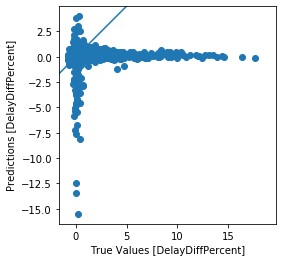

In [46]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

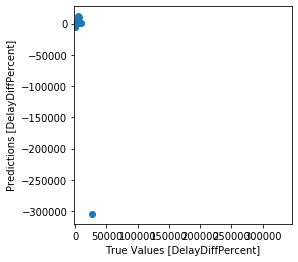

In [47]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:6673.548828125
Najväčšia chyba v zápornom smere:-330924.5625
% chýb menších ako 2 minúty: 0.9558416487033066


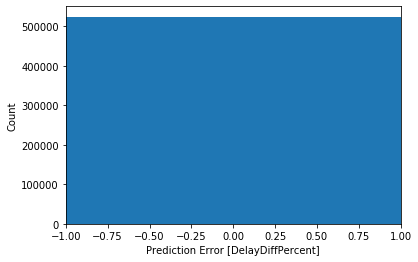

In [48]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

# uprava iba na 2 posledne meskania

In [49]:
casovy_rad = ['Ar1', 'Ar2', 'Ar3', 'Ar4', 'Ar5', 'Ar6', 'Ar7', 'Ar8', 'Ar9']
testCasovyRad = ['Weight', 'Length', 'CarCount', 'AxisCount', 'PlanDrivingTime', 'LengthSect', 'SectIdx',
                 'Ar1', 'Ar2',
                 'DelayDiffPercent']

In [50]:
used_attributes = testCasovyRad
label = used_attributes[-1]

In [52]:
cor_vlastnosti = ['Ar1', 'Ar2']
cor_vlastnosti.append(label)
print(cor_vlastnosti)

dffcut = df[cor_vlastnosti]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

['Ar1', 'Ar2', 'DelayDiffPercent']
DelayDiffPercent    1.000000
Ar1                 0.160644
Ar2                 0.054488
Name: DelayDiffPercent, dtype: float64


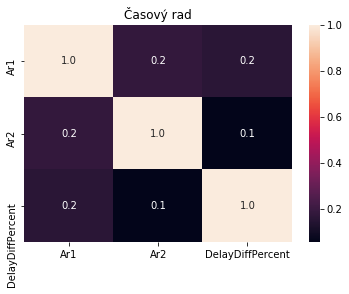

In [53]:
plt.title("Časový rad")
sns.heatmap(cor, annot = True, fmt='.1f')    
plt.show()

In [54]:
dffcut = df[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())   

(2221186, 9)
(555297, 9)
           count        mean         std        min         25%         50%  \
count        9.0    9.000000    9.000000   9.000000    9.000000    9.000000   
mean   2221186.0  139.251137  110.378285  10.168034   62.761111  106.333333   
std          0.0  204.070435  184.135412  28.455242   92.767450  148.252319   
min    2221186.0    0.010502    0.215567  -0.746032   -0.083333    0.000000   
25%    2221186.0    3.569621    2.958493   0.000000    1.000000    3.000000   
50%    2221186.0   46.146443   36.411201   1.000000   12.000000   28.000000   
75%    2221186.0  225.697169  164.337015   2.000000   98.000000  174.000000   
max    2221186.0  592.213798  567.140111  86.000000  224.000000  392.000000   

              75%           max  
count    9.000000      9.000000  
mean   179.118170  10320.085031  
std    251.006507  28703.044536  
min      0.015385     17.902778  
25%      6.000000     19.000000  
50%     76.000000    111.000000  
75%    331.000000    973.

In [55]:
testCasovyRadModel2 = build_model()
print(testCasovyRadModel2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
testCasovyRad2Fit = testCasovyRadModel2.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop, PrintDot()])


...............................

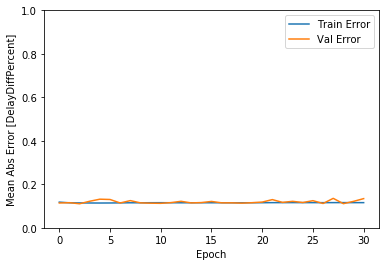

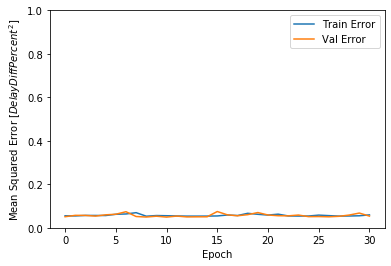

In [57]:
plot_history_Percent(testCasovyRad2Fit, train_dataset['PlanDrivingTime'])

## Vyhodnotenie


In [58]:
test_predictions = testCasovyRadModel2.predict(normed_test_data).flatten()

In [59]:
inter = getDrivingTime(test_predictions,test_dataset['PlanDrivingTime'])
inter_real = getDrivingTime(test_labels,test_dataset['PlanDrivingTime'])

In [60]:
errors = inter - inter_real

In [61]:
eval_Percent(errors)

MAE:
42.19376788292202
MSE:
79413.4725035644
RMSE:
281.80396112113897


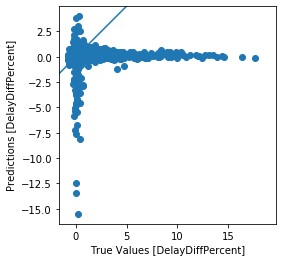

In [46]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

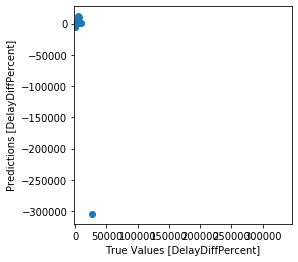

In [47]:
plt.scatter(getDrivingTime(test_labels, test_dataset['PlanDrivingTime']), getDrivingTime(test_predictions,  test_dataset['PlanDrivingTime']))
plt.xlabel('True Values [DelayDiffPercent]')
plt.ylabel('Predictions [DelayDiffPercent]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

Najväčšia chyba:6673.548828125
Najväčšia chyba v zápornom smere:-330924.5625
% chýb menších ako 2 minúty: 0.9558416487033066


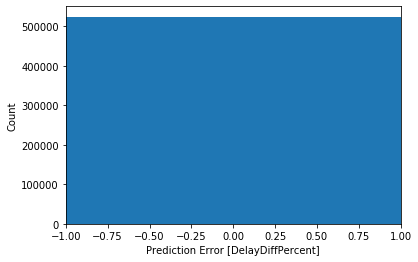

In [48]:
#error = test_predictions - test_labels
error = errors

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1,1])
_ = plt.ylabel("Count")

# Odhad parametrov vlaku na základe jeho jazdných dôb
Očakávam, že presnosť týchto modelov bude o niečo presnejšia, niektoré parametre sa často opakujú na istých trasách, a teda jediným faktor zostáva časová dĺžka trasy ktorá môže priamo rozhodnút o parametri. Avšak očakávam, že týmto dôjde aj k pretrénovaniu, a na validačnej množine nebude dosahovať dostatočne presné výsledky.

In [31]:
odhadParameters = []
dfPar = pd.DataFrame()

In [32]:
type = df['FromName']
for zastavka in fromStops:
    odhadParameters.append("From" + zastavka)
    dfPar["From" + zastavka] = (type == zastavka)*1.0

In [33]:
type = df['ToName']
for zastavka in toStops:
    odhadParameters.append("To" + zastavka)
    dfPar["To" + zastavka] = (type == zastavka)*1.0

In [34]:
dfPar["RealDrivingTime"] = df["RealDrivingTime"]

In [35]:
odhadParameters.append("RealDrivingTime")

# Odhad počtu vagónov v súprave

In [33]:
dfPar['CarCount'] = df['CarCount']
label = 'CarCount'
used_attributes = odhadParameters.copy()
used_attributes.append('CarCount')

In [34]:
dffcut = dfPar[used_attributes]

cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

CarCount                 1.000000
RealDrivingTime          0.180204
ToPolom                  0.047795
FromPolom                0.047792
FromLipník nad Beèv.     0.029333
ToLipník nad Beèv.       0.029137
ToDrahotue              0.029021
FromDrahotue            0.028987
ToProsenice              0.028896
FromProsenice            0.028313
ToHranice na Mor.        0.027500
FromHranice na Mor.      0.026399
FromSuchdol nad Odr.     0.017170
ToSuchdol nad Odr.       0.015558
FromPøerov os.n.         0.013290
ToPøerov os.n.           0.012645
ToJistebník              0.008775
FromJistebník            0.008766
ToPolanka n. O.          0.007414
FromPolanka n. O.        0.004186
ToVýh Dluhonice          0.001162
FromVýh Dluhonice        0.000833
FromCement Hranice      -0.000074
ToFulnek                -0.004665
FromFulnek              -0.005025
ToStudénka              -0.020361
FromStudénka            -0.022615
FromHranice mìsto       -0.025539
ToHranice mìsto         -0.030617
FromOstrava-Ví

In [35]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe())

(2067026, 44)
(516757, 44)
       FromOdb Skalka  FromOstrava-Svinov  FromPolanka n. O.  FromJistebník  \
count    2.067026e+06        2.067026e+06       2.067026e+06   2.067026e+06   
mean     6.187113e-15        1.022564e-14      -3.276275e-15   3.326076e-15   
std      1.000000e+00        1.000000e+00       1.000000e+00   1.000000e+00   
min     -1.455914e-01       -2.405279e-01      -3.064463e-01  -3.070316e-01   
25%     -1.455914e-01       -2.405279e-01      -3.064463e-01  -3.070316e-01   
50%     -1.455914e-01       -2.405279e-01      -3.064463e-01  -3.070316e-01   
75%     -1.455914e-01       -2.405279e-01      -3.064463e-01  -3.070316e-01   
max      6.868536e+00        4.157520e+00       3.263213e+00   3.256993e+00   

       FromStudénka  FromSuchdol nad Odr.     FromPolom  FromHranice na Mor.  \
count  2.067026e+06          2.067026e+06  2.067026e+06         2.067026e+06   
mean  -4.444105e-15         -6.402715e-15 -1.802550e-15        -1.070819e-15   
std    1.000000e+00  

In [53]:
testParModelCarCount0_01 = build_model(0.1)
#print(testParModelCarCount0_01.summary())

In [54]:
testParModelCarCountFit = testParModelCarCount0_01.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model("testParModelCarCount0_01.h5"), PrintDot()])


.............

In [76]:
#testParModel.save("CarCountModel.h5")

In [55]:
testmodel = load_model("testParModelCarCount0_01.h5")

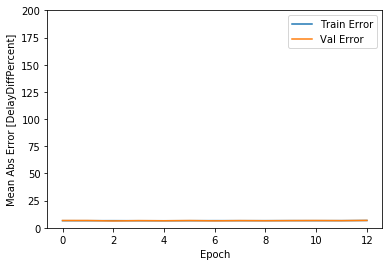

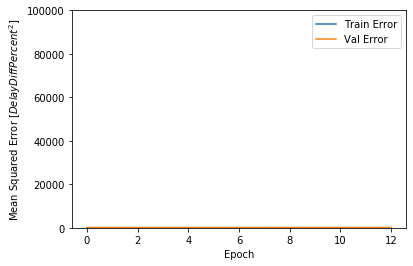

In [56]:
plot_history(testParModelCarCountFit)

In [57]:
eval(testmodel)

Testing set Loss : 78.79 RealDrivingTime
Testing set Mean Abs Error:  6.30 RealDrivingTime
Testing set Mean Sqrt Error: 78.79 RealDrivingTime
Testing set Root Mean Sqrt Error:  8.88 RealDrivingTime


## Vyhodnotenie
Pred Odstánením vlakov s jedným vagónom 
- Testing set Mean Abs Error:  6.04 RealDrivingTime
- Testing set Mean Sqrt Error: 70.75 RealDrivingTime
- Testing set Root Mean Sqrt Error:  8.41 RealDrivingTime

Po filtrácií
- Testing set Mean Abs Error:  5.88 RealDrivingTime
- Testing set Mean Sqrt Error: 69.18 RealDrivingTime
- Testing set Root Mean Sqrt Error:  8.32 RealDrivingTime

Model sa iba minimálne zlepšíl, ale hlavne z dôvodu, že sa naučil na dátach, ktoré už nemali chyby, a tým sa zameral na presné dáta, ktoré majú v niektorch prípadoch viac vagónov, a práve k týmto dátam, sa model priblížil.

Model však aj napriek tomu, nedokáže modelovať danú vlastnosť, a úspešne sa trafí iba v 57% prípadov, s odchýlkou 5 vagónov

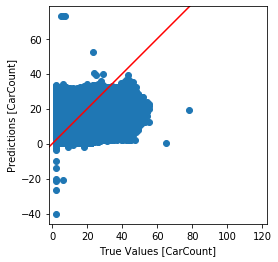

In [50]:
test_predictions = testmodel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [CarCount]')
plt.ylabel('Predictions [CarCount]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100],'r')

Najväčšia chyba:67.81771850585938
Najväčšia chyba v zápornom smere:-64.58448028564453
% priblizne správnych: 0.5794270808136126


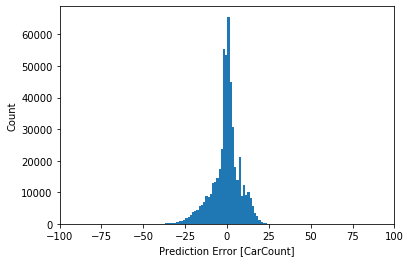

In [51]:
error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 5] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Prediction Error [CarCount]')
plt.xlim([-100,100])
_ = plt.ylabel("Count")

# Experiment - odhad počtu vagónov pomocou modelu vytvoreného pre daný úsek
Vybrané úseky  
    - Drahotuše -> Lipník nad Bečv. 
    - Ostrava-Svinov -> Polanka n. O.

In [62]:
dfPar['CarCount'] = df['CarCount']
label = 'CarCount'
used_attributes = ['RealDrivingTime', 'CarCount']

In [111]:
dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
#dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]
dffcut = dffcut[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

print(dffcut.shape)

CarCount           1.000000
RealDrivingTime    0.220949
Name: CarCount, dtype: float64
(105587, 2)


Ako na prvý pohľad vidím, tak model nebude môcť odhadnúť z jazdnej doby počet vozňov, čo nám potvrdzuje ako korelácia, tak aj graf závislosti týchto dvoch vlastností.

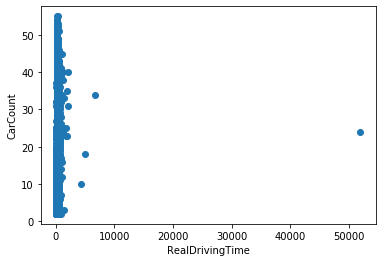

In [112]:
plt.scatter(dffcut['RealDrivingTime'],dffcut['CarCount'])
plt.ylabel('CarCount')
plt.xlabel('RealDrivingTime')
plt.show()

In [113]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  


print(train_stats.describe())
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.describe()) 

(84470, 1)
(21117, 1)
         count        mean         std   min    25%    50%    75%      max
count      1.0    1.000000    1.000000   1.0    1.0    1.0    1.0      1.0
mean   84470.0  193.734497  192.275204  67.0  148.0  176.0  222.0  51933.0
std        NaN         NaN         NaN   NaN    NaN    NaN    NaN      NaN
min    84470.0  193.734497  192.275204  67.0  148.0  176.0  222.0  51933.0
25%    84470.0  193.734497  192.275204  67.0  148.0  176.0  222.0  51933.0
50%    84470.0  193.734497  192.275204  67.0  148.0  176.0  222.0  51933.0
75%    84470.0  193.734497  192.275204  67.0  148.0  176.0  222.0  51933.0
max    84470.0  193.734497  192.275204  67.0  148.0  176.0  222.0  51933.0
       RealDrivingTime
count     8.447000e+04
mean     -1.098870e-17
std       1.000000e+00
min      -6.591307e-01
25%      -2.378596e-01
50%      -9.223497e-02
75%       1.470054e-01
max       2.690896e+02


In [114]:
testParModelCarCountOneTrack = build_model()


....................

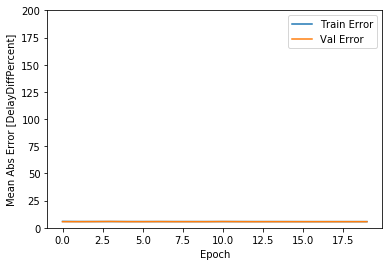

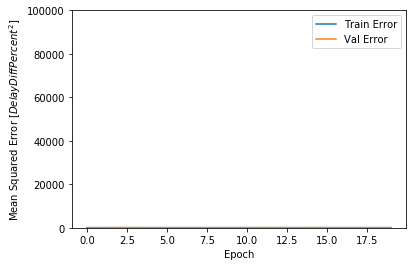

In [115]:
testFit = testParModelCarCountOneTrack.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("testParModelCarCountOneTrack.h5"),early_stop,reduce_lr, PrintDot()])
plot_history(testFit)

In [116]:
testParModelLengthOneTrack = load_model('testParModelCarCountOneTrack.h5')
eval(testParModelCarCountOneTrack)

Testing set Loss : 64.32 RealDrivingTime
Testing set Mean Abs Error:  5.69 RealDrivingTime
Testing set Mean Sqrt Error: 64.32 RealDrivingTime
Testing set Root Mean Sqrt Error:  8.02 RealDrivingTime


## Vyhodnotenie
Vidím, že zameranie sa na jeden úsek pomáha presnoti modelu, ale model dokáže iba do istej miery predpovedať, kde sa trafí v 51% prípadov s odchýlkou 4 vagónov, takže stále ho nepovažujeme za dostatočne presný.

pre trasu Drahotuše -> Lipník nad Bečv. 
- Testing set Mean Abs Error:  5.67 RealDrivingTime
- Testing set Mean Sqrt Error: 63.85 RealDrivingTime
- Testing set Root Mean Sqrt Error:  7.99 RealDrivingTime
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error:  5.69 RealDrivingTime
- Testing set Mean Sqrt Error: 64.32 RealDrivingTime
- Testing set Root Mean Sqrt Error:  8.02 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

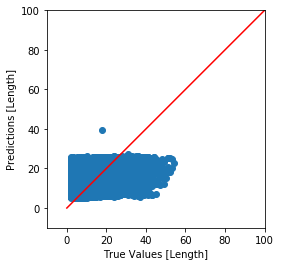

Najväčšia chyba:23.774511337280273
Najväčšia chyba v zápornom smere:-37.685028076171875
% priblizne správnych: 0.5149405692096415


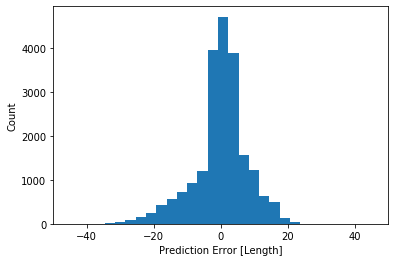

In [117]:
test_predictions = testParModelCarCountOneTrack.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Length]')
plt.ylabel('Predictions [Length]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,100])
plt.ylim([-10,100])
_ = plt.plot([0,100],[0,100],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 4] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=20)
plt.xlabel('Prediction Error [Length]')
plt.xlim([-50,50])
_ = plt.ylabel("Count")

# Odhad počtu náprav v súprave

In [118]:
dfPar['AxisCount'] = df['AxisCount']
label = 'AxisCount'
used_attributes = odhadParameters.copy()
used_attributes.append('AxisCount')

In [119]:
dffcut = dfPar[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

AxisCount                1.000000
RealDrivingTime          0.172168
ToPolom                  0.048755
FromPolom                0.048755
FromLipník nad Beèv.     0.030251
ToLipník nad Beèv.       0.030051
ToDrahotue              0.029940
FromDrahotue            0.029889
ToProsenice              0.029778
FromProsenice            0.029208
ToHranice na Mor.        0.028383
FromHranice na Mor.      0.027313
FromPøerov os.n.         0.016232
ToPøerov os.n.           0.015783
FromSuchdol nad Odr.     0.015300
ToSuchdol nad Odr.       0.013674
ToJistebník              0.009322
FromJistebník            0.009314
ToPolanka n. O.          0.007954
FromPolanka n. O.        0.004332
FromCement Hranice      -0.000075
ToVýh Dluhonice         -0.000860
FromVýh Dluhonice       -0.001091
ToFulnek                -0.005070
FromFulnek              -0.005461
ToStudénka              -0.023286
FromHranice mìsto       -0.025480
FromStudénka            -0.025517
FromOstrava-Vítkovice   -0.027700
ToOstrava-Vítk

In [121]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


(2067026, 44)
(516757, 44)


In [128]:
testParModelAxis = build_model(0.001)


...................

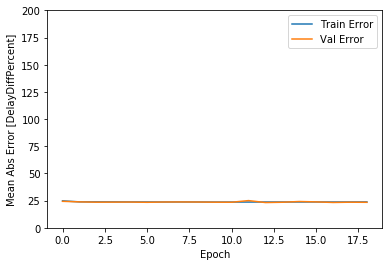

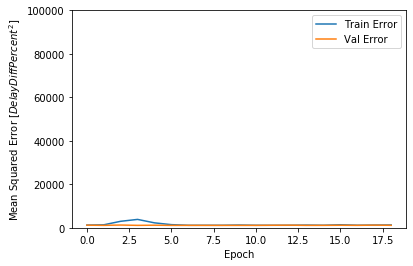

In [129]:
testParModelAxisFit = testParModelAxis.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[save_best_model("AxisModel.h5"),early_stop, PrintDot()])
plot_history(testParModelAxisFit)

In [130]:
testmodel = load_model("AxisModel.h5")

In [131]:
eval(testmodel)

Testing set Loss : 1105.65 RealDrivingTime
Testing set Mean Abs Error: 23.65 RealDrivingTime
Testing set Mean Sqrt Error: 1105.65 RealDrivingTime
Testing set Root Mean Sqrt Error: 33.25 RealDrivingTime


## Vyhodnotenie

- Testing set Mean Abs Error: 23.65 RealDrivingTime
- Testing set Mean Sqrt Error: 1105.65 RealDrivingTime
- Testing set Root Mean Sqrt Error: 33.25 RealDrivingTime

Model správne odhadne 58% prípadov s ochýlkou 20 náprav. Nestačí to na to, aby som ho označil za dotatočne presný

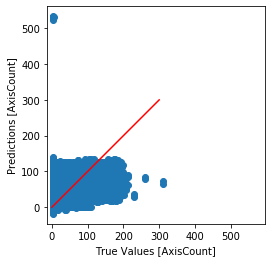

Najväčšia chyba:529.8419799804688
Najväčšia chyba v zápornom smere:-245.80941772460938
% chýb menších ako 20 náprav: 0.5790903654909367


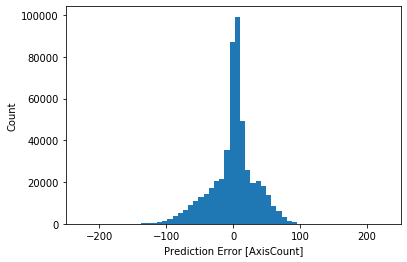

In [134]:
test_predictions = testmodel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [AxisCount]')
plt.ylabel('Predictions [AxisCount]')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([0,300],[0,300],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodError = error[abs(error) < 20] 
print("% chýb menších ako 20 náprav: " + str(len(goodError)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Prediction Error [AxisCount]')
plt.xlim([-250,250])
_ = plt.ylabel("Count")

## Experiment - odhad počtu náprav na modeli konkrétneho úseku
Vybrané úseky  
    - Drahotuše -> Lipník nad Bečv. 
    - Ostrava-Svinov -> Polanka n. O.

In [137]:
label = 'AxisCount'
dfPar[label] = df[label]
used_attributes = ['RealDrivingTime', label]

In [150]:
#dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]
dffcut = dffcut[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

print(dffcut.shape)

AxisCount          1.000000
RealDrivingTime    0.356696
Name: AxisCount, dtype: float64
(116955, 2)


Ako na prvý pohľad vidím, tak model nebude môcť odhadnúť z jazdnej doby počet náprav, čo nám potvrdzuje ako korelácia, tak aj graf závislosti týchto dvoch vlastností.

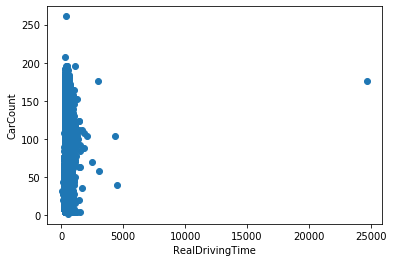

In [151]:
plt.scatter(dffcut['RealDrivingTime'],dffcut[label])
plt.ylabel(label)
plt.xlabel('RealDrivingTime')
plt.show()

In [152]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(93564, 1)
(23391, 1)


In [153]:
testParModelAxisCountOneTrack = build_model()


....................
.

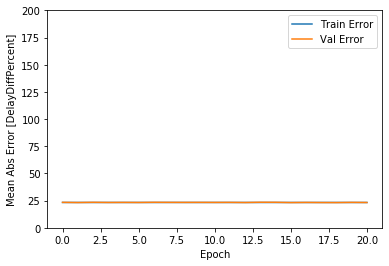

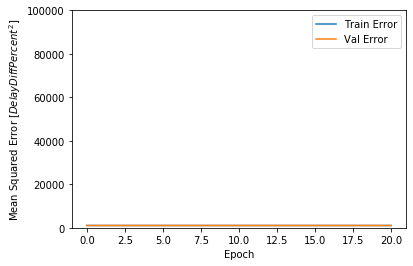

In [156]:
testFit = testParModelAxisCountOneTrack.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("AxisModelOneTrack.h5"),early_stop,reduce_lr, PrintDot()])
plot_history(testFit)

In [157]:
testParModelAxisCountOneTrack = load_model('AxisModelOneTrack.h5')
eval(testParModelAxisCountOneTrack)

Testing set Loss : 1036.08 RealDrivingTime
Testing set Mean Abs Error: 23.11 RealDrivingTime
Testing set Mean Sqrt Error: 1036.08 RealDrivingTime
Testing set Root Mean Sqrt Error: 32.19 RealDrivingTime


### Vyhodnotenie
Vidím, že zameranie sa na jeden úsek nepomáha výrazne presnoti modelu, kde sa trafí s podobnou presnoťou ako predošlý model v 52% prípadoch s odchýlkou 16 náprav, takže stále ho nepovažujeme za dostatočne presný.

pre trasu Drahotuše -> Lipník nad Bečv. 
- Testing set Mean Abs Error: 23.11 RealDrivingTime
- Testing set Mean Sqrt Error: 1036.08 RealDrivingTime
- Testing set Root Mean Sqrt Error: 32.19 RealDrivingTime
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error: 22.75 RealDrivingTime
- Testing set Mean Sqrt Error: 1001.90 RealDrivingTime
- Testing set Root Mean Sqrt Error: 31.65 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

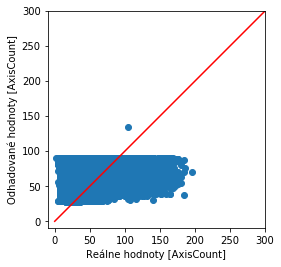

Najväčšia chyba:388.70989990234375
Najväčšia chyba v zápornom smere:-146.8528594970703
% priblizne správnych: 0.5108375016031808


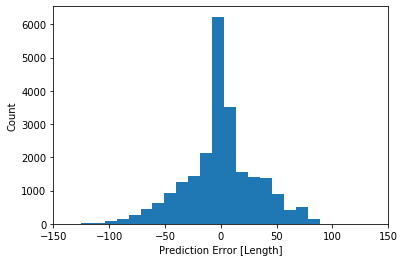

In [158]:
test_predictions = testParModelAxisCountOneTrack.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Reálne hodnoty [' + label + ']')
plt.ylabel('Odhadované hodnoty [' + label + ']')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,300])
plt.ylim([-10,300])
_ = plt.plot([0,300],[0,300],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 16] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=50)
plt.xlabel('Prediction Error [Length]')
plt.xlim([-150,150])
_ = plt.ylabel("Count")

# Odhad dĺžky vlakovej súpravy

In [159]:
label = 'Length'
dfPar[label] = df[label]
used_attributes = odhadParameters.copy()
used_attributes.append(label)

In [160]:
dffcut = dfPar[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

Length                   1.000000
RealDrivingTime          0.124322
FromPolom                0.055862
ToPolom                  0.055856
FromLipník nad Beèv.     0.040115
ToLipník nad Beèv.       0.039873
ToDrahotue              0.039670
FromDrahotue            0.039590
ToProsenice              0.039507
FromProsenice            0.039038
ToHranice na Mor.        0.034293
FromHranice na Mor.      0.033154
FromSuchdol nad Odr.     0.015485
ToSuchdol nad Odr.       0.013534
FromPøerov os.n.         0.013007
ToVýh Dluhonice          0.011850
FromVýh Dluhonice        0.011399
ToPøerov os.n.           0.010202
ToJistebník              0.009571
FromJistebník            0.009517
ToPolanka n. O.          0.007556
FromPolanka n. O.        0.002958
FromCement Hranice      -0.000301
ToFulnek                -0.005987
FromFulnek              -0.006446
FromHranice mìsto       -0.029710
ToStudénka              -0.030096
FromStudénka            -0.032773
ToHranice mìsto         -0.034462
FromOstrava-Ví

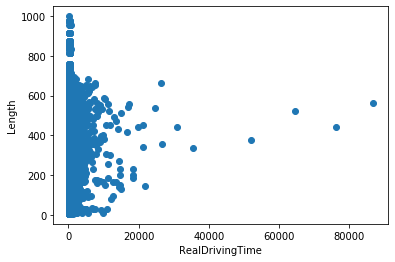

In [161]:
plt.scatter(dffcut['RealDrivingTime'],dffcut[label])
plt.ylabel(label)
plt.xlabel('RealDrivingTime')
plt.show()

In [162]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(2067026, 44)
(516757, 44)


In [166]:
testParModelLength = build_model(0.001)


....................
..

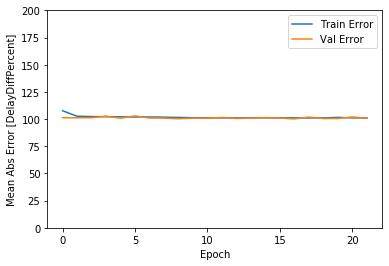

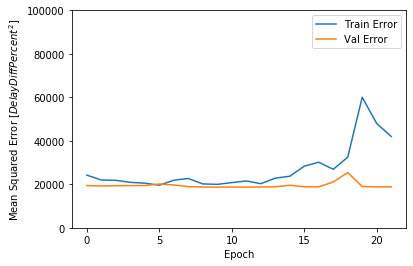

In [167]:
testParModelLengthFit = testParModelLength.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[reduce_lr,early_stop,save_best_model("testParModelLengthGeneral.h5"), PrintDot()])
plot_history(testParModelLengthFit)

In [168]:
testModel = load_model('testParModelLengthGeneral.h5')
eval(testModel)

Testing set Loss : 18653.71 RealDrivingTime
Testing set Mean Abs Error: 101.29 RealDrivingTime
Testing set Mean Sqrt Error: 18653.76 RealDrivingTime
Testing set Root Mean Sqrt Error: 136.58 RealDrivingTime


## Vyhodnotenie
Model sa priblížil iba v 25% testovacích prípadov, čo nieje ani zdaľeka dostatočné

- Testing set Mean Abs Error: 101.29 RealDrivingTime
- Testing set Mean Sqrt Error: 18653.76 RealDrivingTime
- Testing set Root Mean Sqrt Error: 136.58 RealDrivingTime

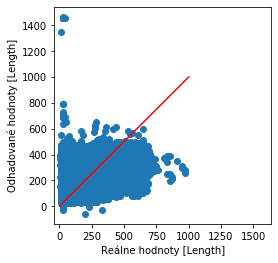

Najväčšia chyba:1438.185791015625
Najväčšia chyba v zápornom smere:-715.02392578125
% priblizne správnych: 0.2601493545322076


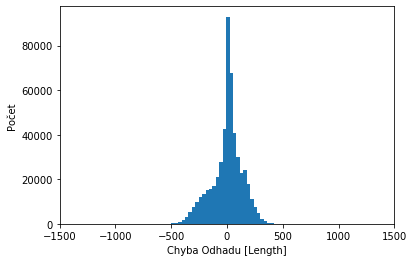

In [175]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Reálne hodnoty ['+label+']')
plt.ylabel('Odhadované hodnoty ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([0,1000],[0,1000], 'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 28] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=70)
plt.xlabel('Chyba Odhadu ['+label+']')
plt.xlim([-1500,1500])
_ = plt.ylabel("Počet")


# Experiment Odhad dĺžky vlakovej súpravy na konkrétnom úseku
Mojim cieľom je zistiť, či model vytvorený pre špecifický úsek je presnejší ako model s použitím one-hot encoding

In [176]:
label = 'Length'
dfPar[label] = df[label]
used_attributes = ['RealDrivingTime', label]

In [182]:
dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
#dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]

dffcut = dffcut[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

print(dffcut.shape)

Length             1.000000
RealDrivingTime    0.193244
Name: Length, dtype: float64
(105587, 2)


In [183]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(84470, 1)
(21117, 1)


In [184]:
testParModelLengthOneTrack = build_model()


....................

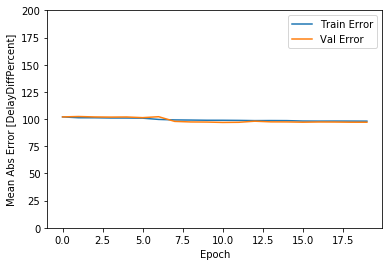

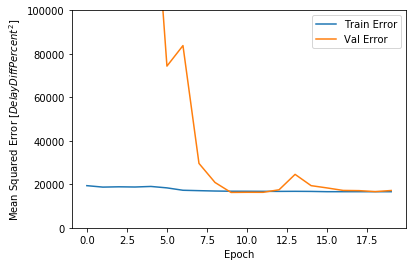

In [185]:
testParModelLengthFit = testParModelLengthOneTrack.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("testParModelLengthOneTrack.h5"),early_stop,reduce_lr, PrintDot()])
plot_history(testParModelLengthFit)

In [186]:
testModel = load_model('testParModelLengthOneTrack.h5')
eval(testModel)

Testing set Loss : 16650.66 RealDrivingTime
Testing set Mean Abs Error: 98.56 RealDrivingTime
Testing set Mean Sqrt Error: 16650.65 RealDrivingTime
Testing set Root Mean Sqrt Error: 129.04 RealDrivingTime


## Vyhodnotenie
Zameranie sa na jeden úsek sa zdá že nepomáha presnoti modelu, a trafí sa iba v 20% prípadov s odchýlkou 28 metrov čo je  5% horší výsledok. Teda usudzujem, že sa nedá odhadnúť dĺžka vlaku z jeho jazdnej doby.

pre trasu Drahotuše -> Lipník nad Bečv. 
- Testing set Mean Abs Error: 102.28 RealDrivingTime
- Testing set Mean Sqrt Error: 18510.44 RealDrivingTime
- Testing set Root Mean Sqrt Error: 136.05 RealDrivingTime
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error: 98.56 RealDrivingTime
- Testing set Mean Sqrt Error: 16650.65 RealDrivingTime
- Testing set Root Mean Sqrt Error: 129.04 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

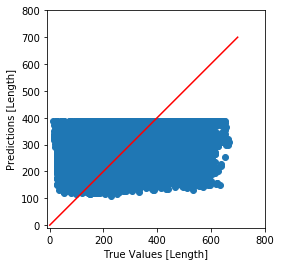

Najväčšia chyba:375.17572021484375
Najväčšia chyba v zápornom smere:-709.595703125
% priblizne správnych: 0.2079367334375148


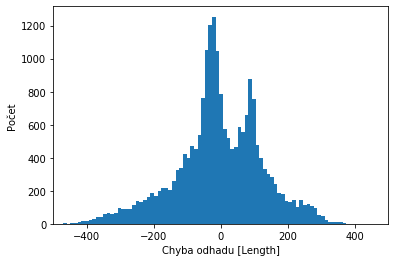

In [187]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+label+']')
plt.ylabel('Predictions ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,800])
plt.ylim([-10,800])
_ = plt.plot([0,700],[0,700],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 28] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Chyba odhadu ['+label+']')
plt.xlim([-500,500])
_ = plt.ylabel("Počet")

# Odhad váhy vlakovej súpravy

In [189]:
label = 'Weight'
dfPar[label] = df[label]
used_attributes = odhadParameters.copy()
used_attributes.append(label)

In [190]:
dffcut = dfPar[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

Weight                   1.000000
RealDrivingTime          0.150296
ToPolom                  0.045031
FromPolom                0.045026
ToPøerov os.n.           0.036322
FromLipník nad Beèv.     0.028945
FromDrahotue            0.028291
ToDrahotue              0.028052
ToProsenice              0.027888
ToLipník nad Beèv.       0.027730
FromProsenice            0.027297
ToHranice na Mor.        0.026508
FromHranice na Mor.      0.025630
FromSuchdol nad Odr.     0.013425
ToSuchdol nad Odr.       0.011986
ToVýh Dluhonice          0.009483
ToJistebník              0.008757
FromJistebník            0.008750
ToPolanka n. O.          0.006825
FromPolanka n. O.        0.004491
FromCement Hranice       0.000217
ToFulnek                -0.004750
FromFulnek              -0.005099
FromVýh Dluhonice       -0.005510
FromOstrava-Svinov      -0.011271
FromPøerov os.n.        -0.012418
ToOstrava-Vítkovice     -0.021138
ToStudénka              -0.021968
FromStudénka            -0.024248
FromHranice mì

In [191]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(2067026, 44)
(516757, 44)


In [200]:
testParModelWeight = build_model(0.001)


....................
....................
.......

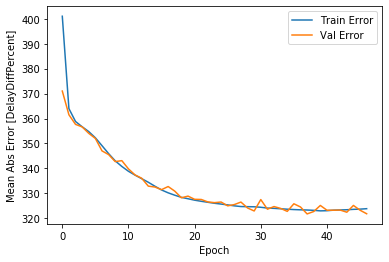

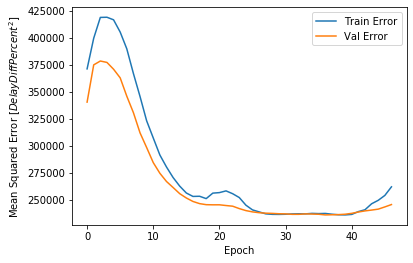

In [201]:
testParModelWeightFit = testParModelWeight.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop,save_best_model("testParModelWeightGeneral.h5"), PrintDot()])
plot_history(testParModelWeightFit)

In [202]:
testModel = load_model("testParModelWeightGeneral.h5")
eval(testModel)

Testing set Loss : 233971.17 RealDrivingTime
Testing set Mean Abs Error: 323.74 RealDrivingTime
Testing set Mean Sqrt Error: 233970.70 RealDrivingTime
Testing set Root Mean Sqrt Error: 483.71 RealDrivingTime


## Vyhodnotenie
Vidím že tento model nedokáže spoľahlivo predpovedať váhu vlaku
- Testing set Mean Abs Error: 323.74 RealDrivingTime
- Testing set Mean Sqrt Error: 233970.70 RealDrivingTime
- Testing set Root Mean Sqrt Error: 483.71 RealDrivingTime

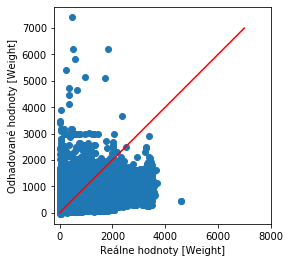

Najväčšia chyba:6980.16455078125
Najväčšia chyba v zápornom smere:-4152.72314453125


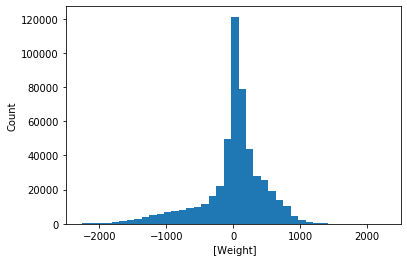

In [206]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Reálne hodnoty ['+label+']')
plt.ylabel('Odhadované hodnoty ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([0,7000],[0,7000], 'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

plt.hist(error, bins=100)
plt.xlabel(' ['+label+']')
plt.xlim([-2500,2500])
_ = plt.ylabel("Count")

# Experiment Odhad váhy vlakovej súpravy na konkrétnom úseku
Mojim cieľom je zistiť, či model vytvorený pre špecifický úsek je presnejší ako model s použitím one-hot encoding

In [207]:
label = 'Weight'
dfPar[label] = df[label]
used_attributes = ['RealDrivingTime', label]

In [225]:
#dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]

dffcut = dffcut[used_attributes]
cor = dffcut.corr()
print(cor[label].sort_values(ascending=False))

print(dffcut.shape)

Weight             1.000000
RealDrivingTime    0.322788
Name: Weight, dtype: float64
(116955, 2)


In [226]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(93564, 1)
(23391, 1)


In [231]:
testParModelWeightOneTrack = build_model(0.005)


....................
....................
..........

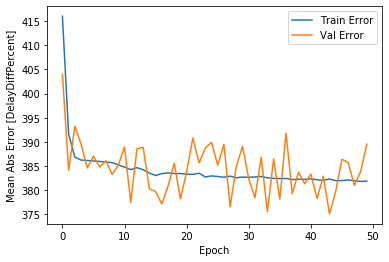

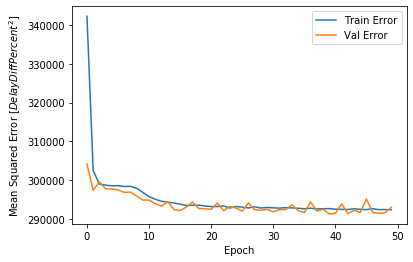

In [232]:
WeightOneTrackHistory = testParModelWeightOneTrack.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("testParModelWeightOneTrack.h5"),early_stop, PrintDot()])
plot_history(WeightOneTrackHistory)

In [233]:
testModel = load_model('testParModelWeightOneTrack.h5')
eval(testModel)

Testing set Loss : 289685.47 RealDrivingTime
Testing set Mean Abs Error: 381.80 RealDrivingTime
Testing set Mean Sqrt Error: 289685.44 RealDrivingTime
Testing set Root Mean Sqrt Error: 538.22 RealDrivingTime


## Vyhodnotenie
Zameranie sa na jeden úsek sa zdá že nepomáha presnoti modelu, a trafí sa iba v 3-6% prípadov. Takéto zhoršenie oproti všeobecnému modelu môže znamenať, že existujú úseky, ktoré sa odhadnúť dajú oveľa lepšie ako moje vybrané. 
pre trasu Drahotuše -> Lipník nad Bečv. 
- Testing set Mean Abs Error: 381.80 RealDrivingTime
- Testing set Mean Sqrt Error: 289685.44 RealDrivingTime
- Testing set Root Mean Sqrt Error: 538.22 RealDrivingTime
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error: 363.64 RealDrivingTime
- Testing set Mean Sqrt Error: 281428.50 RealDrivingTime
- Testing set Root Mean Sqrt Error: 530.50 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

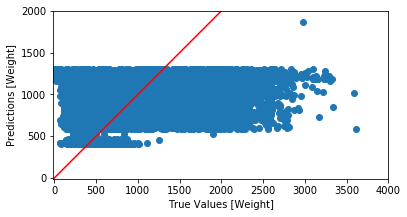

Najväčšia chyba:1298.6484375
Najväčšia chyba v zápornom smere:-3024.20849609375
% priblizne správnych: 0.30866572613398313


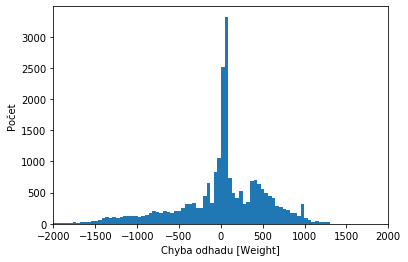

In [240]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+label+']')
plt.ylabel('Predictions ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,4000])
plt.ylim([-10,2000])
_ = plt.plot([0,5000],[0,5000],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 80] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Chyba odhadu ['+label+']')
plt.xlim([-2000,2000])
_ = plt.ylabel("Počet")

# Odhad Typu vlaku

In [209]:
dfPar['TrainType'] = df['TrainType']
label = 'TrainLabel'
used_attributes = odhadParameters.copy()
used_attributes = used_attributes + [label]

In [210]:
dfPar[label] = dfPar['TrainType'].astype('category')
dfPar[label] = dfPar[label].cat.codes

In [211]:
dffcut = dfPar[used_attributes]

train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)


train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(2067026, 44)
(516757, 44)


In [225]:
def build_classification_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(10, activation=tf.nn.softmax)
    ])

    optimizer = tf.keras.optimizers.Adam(0.00001)

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [223]:
testParModelType = build_classification_model()

In [217]:
early_stop_classification = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25)

In [218]:
def plot_class_history(history):
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

In [44]:
def class_eval(model):
    loss, accuracy = model.evaluate(normed_test_data, test_labels, verbose=0)
    print("Testing set Accuracy : {:5.2f} % ".format(accuracy*100))

In [224]:
def save_best_class_model(model_name):
    return keras.callbacks.ModelCheckpoint(model_name, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False)


....................
....................
....................
....................
....................
....................
....................
..........

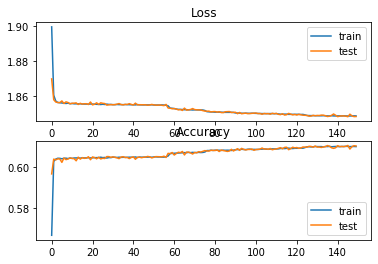

In [226]:
testParModelTypeFit = testParModelType.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.25, verbose=0, callbacks=[early_stop_classification,save_best_model("TestParModelTypeGeneralAdam.h5"), PrintDot()])
plot_class_history(testParModelTypeFit)

In [227]:
testModel = load_model("TestParModelTypeGeneralAdam.h5")
class_eval(testModel)

Testing set Accuracy : 61.04 % 


## Vyhodnotenie
Tento model vykazuje na testovacej mnozine presnost 
- 61.04 %

očakával som väčšiu presnosť.

In [47]:
test_predictions = testModel.predict(normed_test_data)

print(np.argmax(test_predictions[0]))
print(test_labels.iloc[0])

for i in range(10):
    plt.subplot(1,2,2)
    plt.bar(range(10), test_predictions[i])
    plt.title(train_types[test_labels.iloc[i]])
    plt.xticks(range(10), train_types, rotation=45)
    plt.show()

Najväčšia chyba:True
Najväčšia chyba v zápornom smere:True
% chýb menších ako 2 minúty: 1.0


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


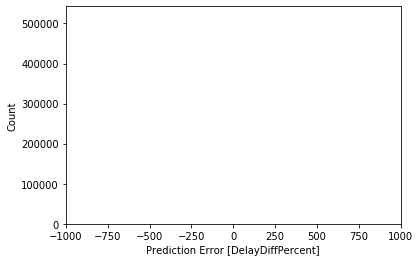

In [327]:
error = (test_predictions != test_labels)

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

lessThan2Min = error[abs(error) < 120] 
print("% chýb menších ako 2 minúty: " + str(len(lessThan2Min)/len(error)))


plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [DelayDiffPercent]')
plt.xlim([-1000,1000])
_ = plt.ylabel("Count")

## Experiment - odhad typu vlaku na základe jazdnej doby na konkrétnom úseku

In [199]:
dfPar['TrainType'] = df['TrainType']
label = 'TrainLabel'
used_attributes = ['TrainLabel','RealDrivingTime']

In [200]:
dfPar[label] = dfPar['TrainType'].astype('category')
dfPar[label] = dfPar[label].cat.codes

In [201]:
dffcut = dfPar[((dfPar['FromOstrava-Svinov'] == 1) & (dfPar['ToPolanka n. O.'] == 1))]
#dffcut = dfPar[((dfPar['FromDrahotue'] == 1) & (dfPar['ToLipník nad Beèv.'] == 1))]

dffcut = dffcut[used_attributes]
print(dffcut.shape)

(105587, 2)


In [202]:
train_dataset = dffcut.sample(frac=0.8, random_state=0)
test_dataset = dffcut.drop(train_dataset.index)

train_labels = train_dataset.pop(label)
test_labels = test_dataset.pop(label)

print(train_dataset.shape)
print(test_dataset.shape)
    
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()  

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

(84470, 1)
(21117, 1)


In [203]:
def build_classification_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(len(train_types), activation=tf.nn.softmax)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [204]:
testTypeModel = build_classification_model()

In [205]:
EPOCHS = 150

In [206]:
early_stop_classification = keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=30)


....................
....................
........

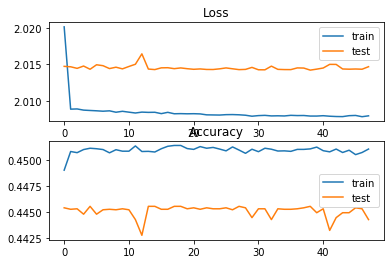

In [207]:
testTypeModelHistory = testTypeModel.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.25, verbose=0, callbacks=[save_best_model("testTypeModelOneTrack.h5"), early_stop_classification, reduce_lr, PrintDot()])
plot_class_history(testTypeModelHistory)

In [208]:
testModel = load_model('testTypeModelOneTrack.h5')
class_eval(testModel)

Testing set Accuracy : 45.12 % 


## Vyhodnotenie
Zameranie sa na jeden úsek sa zdá že nepomáha presnoti modelu, a trafí sa iba v 3-6% prípadov. Takéto zhoršenie oproti všeobecnému modelu môže znamenať, že existujú úseky, ktoré sa odhadnúť dajú oveľa lepšie ako moje vybrané. 
pre trasu Drahotuše -> Lipník nad Bečv. 
- Accuracy: 59.20 % 
    
        - Táto trasa málokedy zaznamená nulové meškanie, preto je dobrým príkladom dobre zaznamenaných dát
        
pre trasu Ostrava-Svinov -> Polanka n. O.
- Testing set Mean Abs Error: 363.64 RealDrivingTime
- Testing set Mean Sqrt Error: 281428.50 RealDrivingTime
- Testing set Root Mean Sqrt Error: 530.50 RealDrivingTime


        - Táto trasa má často ako keby nadiktované výsledky, kde vlaky majú v niektorých prípadoch rovnaké jazdné doby

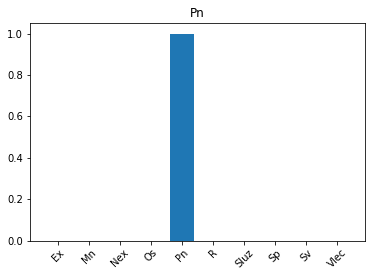

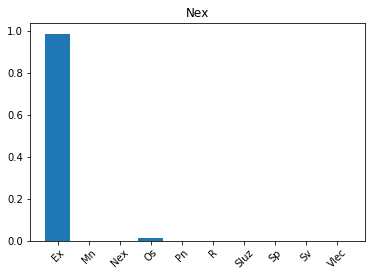

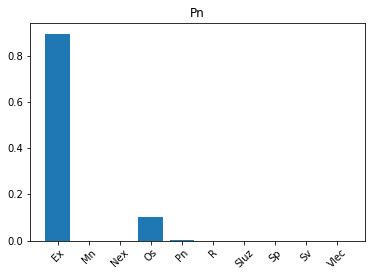

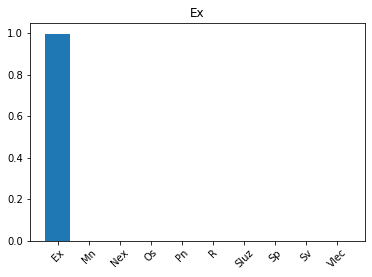

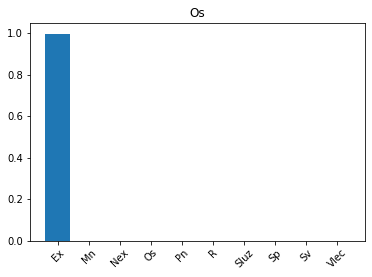

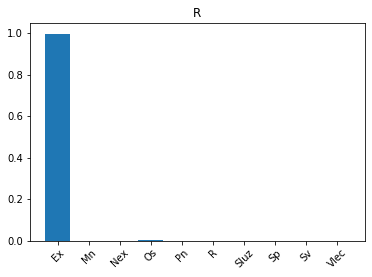

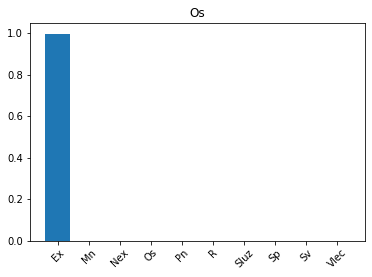

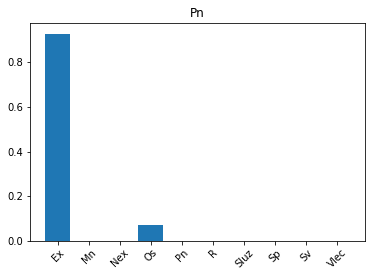

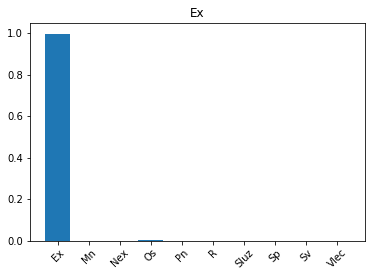

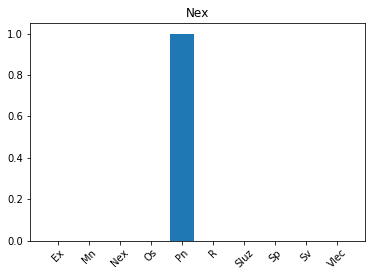

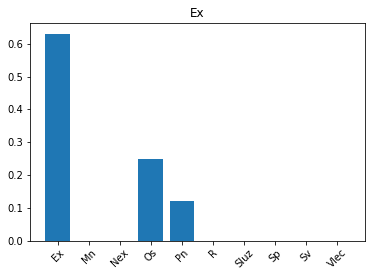

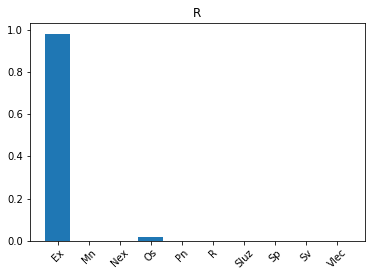

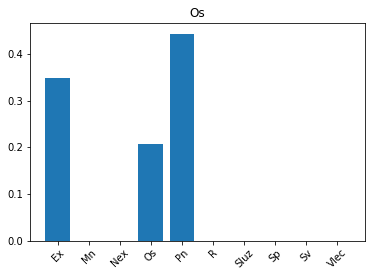

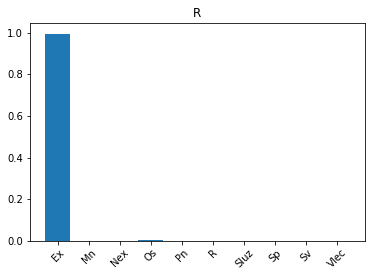

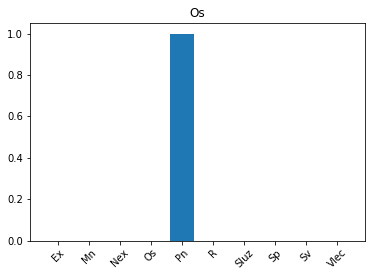

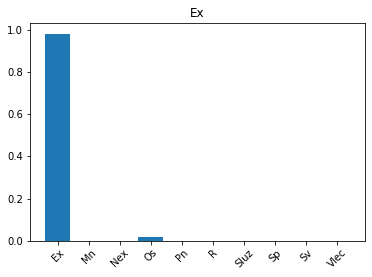

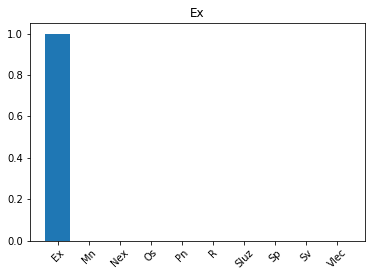

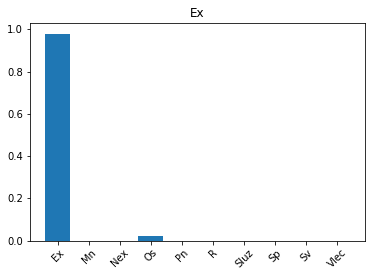

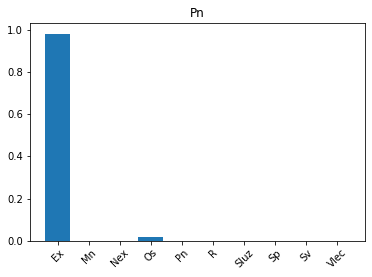

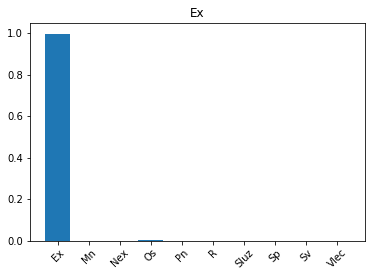

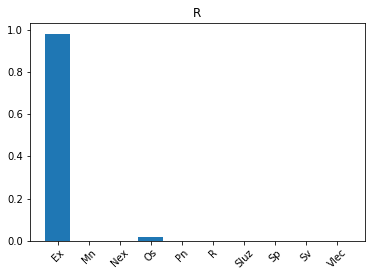

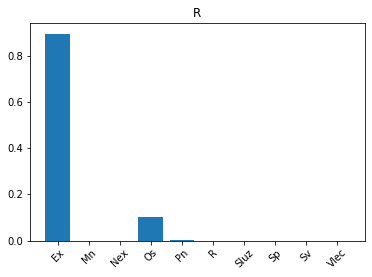

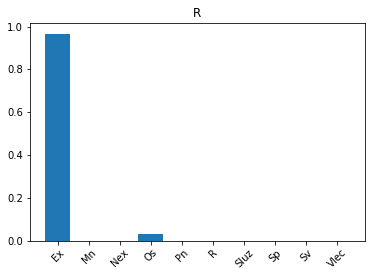

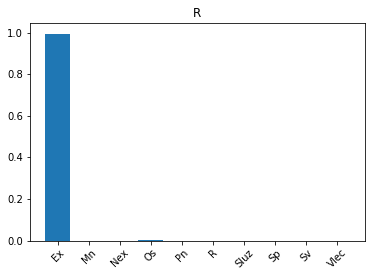

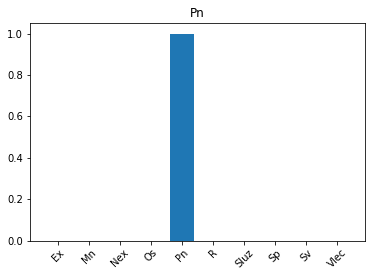

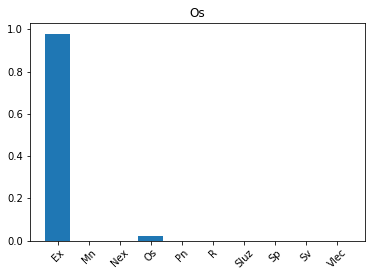

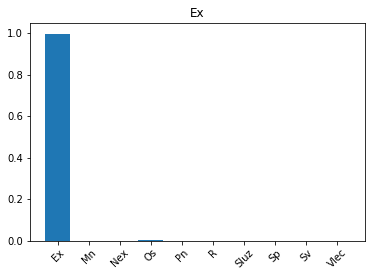

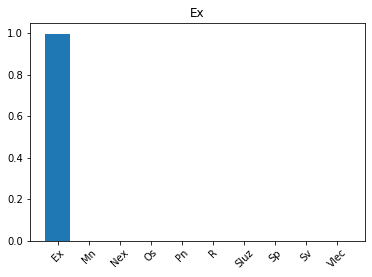

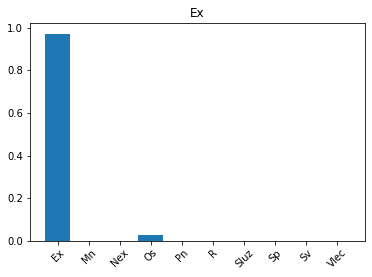

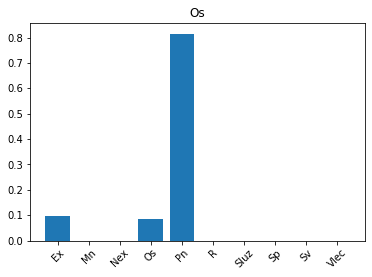

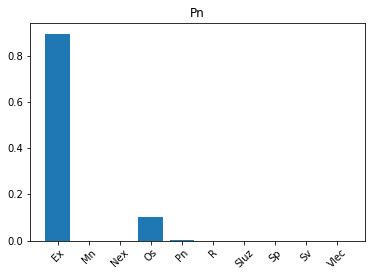

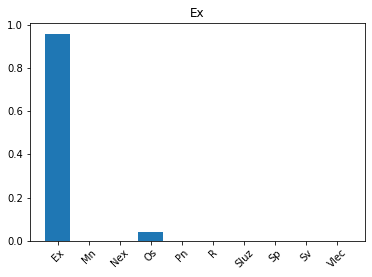

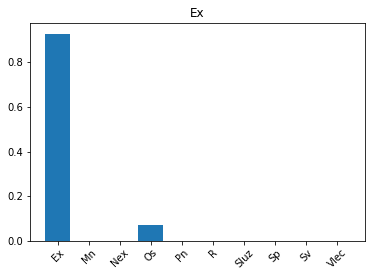

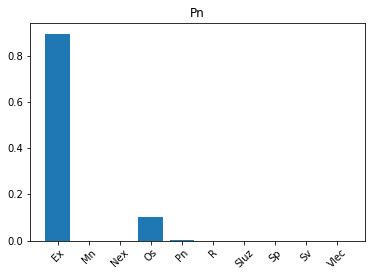

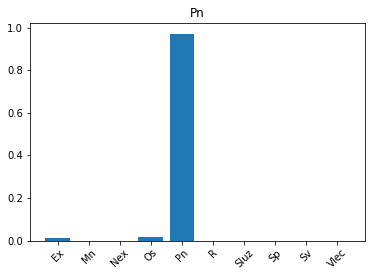

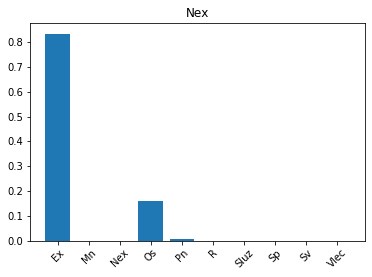

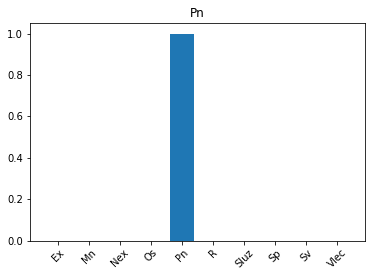

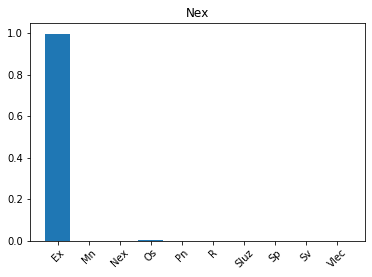

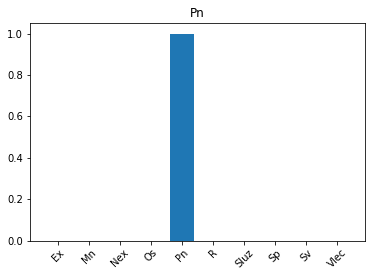

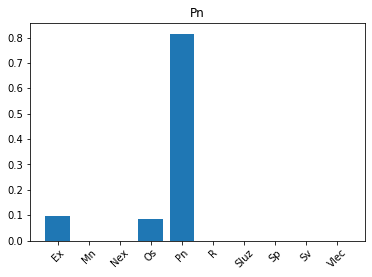

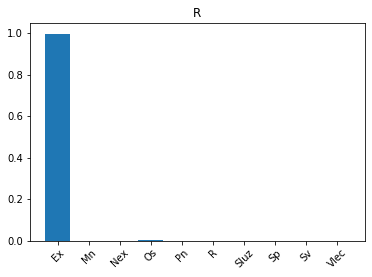

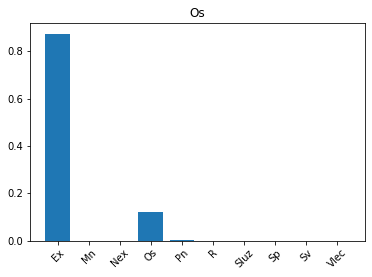

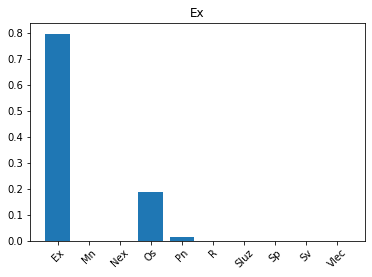

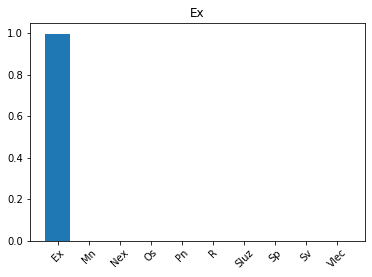

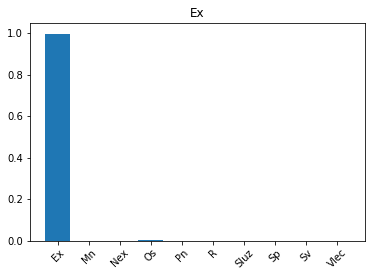

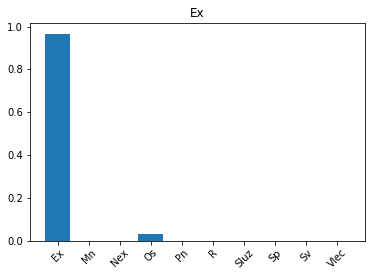

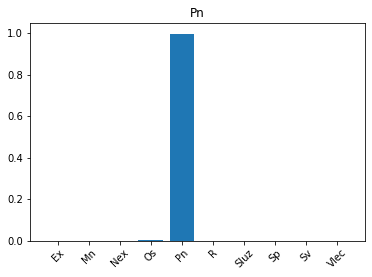

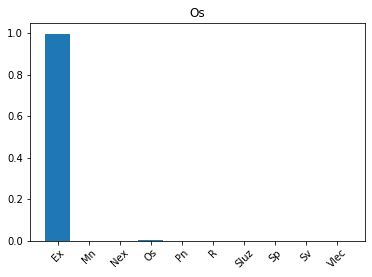

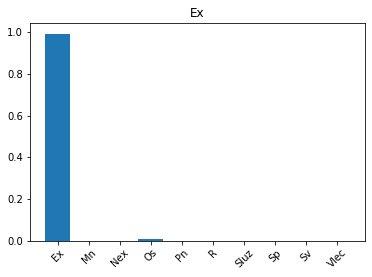

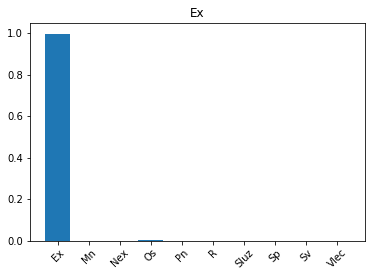

In [113]:
test_predictions = testModel.predict(normed_test_data)


for i in range(50): 
    plt.subplot(1,1,1)
    plt.bar(range(len(train_types)), test_predictions[i])
    plt.title(train_types[test_labels.iloc[i]])
    plt.xticks(range(len(train_types)), train_types, rotation=45)
    plt.show()

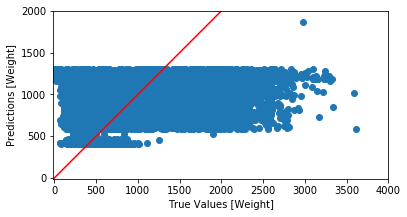

Najväčšia chyba:1298.6484375
Najväčšia chyba v zápornom smere:-3024.20849609375
% priblizne správnych: 0.30866572613398313


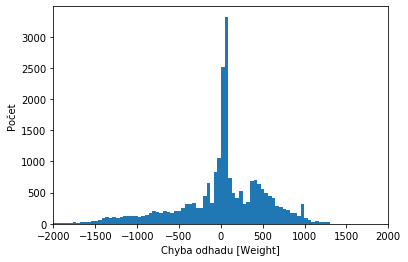

In [240]:
test_predictions = testModel.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+label+']')
plt.ylabel('Predictions ['+label+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,4000])
plt.ylim([-10,2000])
_ = plt.plot([0,5000],[0,5000],'r')
plt.show()

error = test_predictions - test_labels

print("Najväčšia chyba:" + str(max(error)))
print("Najväčšia chyba v zápornom smere:" + str(min(error)))

goodPercent = error[abs(error) < 80] 
print("% priblizne správnych: " + str(len(goodPercent)/len(error)))

plt.hist(error, bins=100)
plt.xlabel('Chyba odhadu ['+label+']')
plt.xlim([-2000,2000])
_ = plt.ylabel("Počet")